In [10]:
import json
import math
import glob
import os
import time
import pickle as pkl
import tqdm

from pathlib import Path

import numpy as np
import torch

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

class print_color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [11]:
! ls /home/jovyan/particleflow/

apptainer  LICENSE    parameters    requirements.txt	 tests
habana	   mlpf       README.md     scripts		 timing.md
images	   notebooks  README_tf.md  tensorflow_datasets


In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# import relevant functions from mlpf.pyg
import sys
sys.path.append("/home/jovyan/particleflow/mlpf/")
import pyg
sys.path.append("/home/jovyan/particleflow/mlpf/pyg/")
import utils

from PFDataset import PFDataset, Collater, InterleavedIterator

from pyg.mlpf import MLPF
from pyg.utils import X_FEATURES, Y_FEATURES, unpack_predictions, unpack_target

In [14]:
# define the global base device
world_size = 1
if torch.cuda.device_count():
    rank = 0
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    rank = "cpu"
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA GeForce GTX 1080 Ti


# CLD dataset

In [17]:
! ls /pfvol/tensorflow_datasets/clic_edm_ttbar_pf

1.5.0


In [18]:
data_dir = "/pfvol/tensorflow_datasets/"

test_list = {}

sample = "clic_edm_ttbar_pf"

split = "train"
# build dataloader for physical and gun samples seperately
dataset_test = PFDataset(
    data_dir,
    f"{sample}:1.5.0",
    split,
    num_samples=8_000,
)

# build dataloaders
batch_size = 10
loader = torch.utils.data.DataLoader(
    dataset_test.ds,
    batch_size=batch_size,
    collate_fn=Collater(["X", "ygen", "ycand"]),
)
test_list[sample] = []
for i, batch in enumerate(tqdm.tqdm(loader)):
    test_list[sample] += [batch]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:34<00:00, 23.34it/s]


In [19]:
# we can see the 17th features here (recall type is 1 for tracks and 2 for clusters)
print(len(X_FEATURES["clic"]))
X_FEATURES["clic"]

17


['type',
 'pt | et',
 'eta',
 'sin_phi',
 'cos_phi',
 'p | energy',
 'chi2 | position.x',
 'ndf | position.y',
 'dEdx | position.z',
 'dEdxError | iTheta',
 'radiusOfInnermostHit | energy_ecal',
 'tanLambda | energy_hcal',
 'D0 | energy_other',
 'omega | num_hits',
 'Z0 | sigma_x',
 'time | sigma_y',
 'Null | sigma_z']

In [20]:
# we can see the 8 gen features per pf element here (notice the jet_index which may be useful)
print(len(Y_FEATURES))
Y_FEATURES

7


['cls_id', 'charge', 'pt', 'eta', 'sin_phi', 'cos_phi', 'energy']

# Plots

In [23]:
outdir = f"/pfvol/plots_foundation_model/CLIC_validation/{sample}"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [30]:
EVALUATION_DATASET_NAMES = {
    "delphes_ttbar_pf": r"Delphes-CMS $pp \rightarrow \mathrm{t}\overline{\mathrm{t}}$",
    "delphes_qcd_pf": r"Delphes-CMS $pp \rightarrow \mathrm{QCD}$",
    "clic_edm_ttbar_pf": r"$e^+e^- \rightarrow \mathrm{t}\overline{\mathrm{t}}$",
    "clic_edm_ttbar_pu10_pf": r"$e^+e^- \rightarrow \mathrm{t}\overline{\mathrm{t}}$, PU10",
    "clic_edm_ttbar_hits_pf": r"$e^+e^- \rightarrow \mathrm{t}\overline{\mathrm{t}}$",
    "clic_edm_qq_pf": r"$e^+e^- \rightarrow \gamma/\mathrm{Z}^* \rightarrow \mathrm{hadrons}$",
    "clic_edm_ww_fullhad_pf": r"$e^+e^- \rightarrow WW \rightarrow \mathrm{hadrons}$",
    "clic_edm_zh_tautau_pf": r"$e^+e^- \rightarrow ZH \rightarrow \tau \tau$",
    "cms_pf_qcd": r"QCD $p_T \in [15, 3000]\ \mathrm{GeV}$+PU",
    "cms_pf_ztt": r"$\mathrm{Z}\rightarrow \mathrm{\tau}\mathrm{\tau}$+PU",
    "cms_pf_ttbar": r"$\mathrm{t}\overline{\mathrm{t}}$+PU",
    "cms_pf_multi_particle_gun": r"multi particle gun events",
    "cms_pf_single_electron": r"single electron particle gun events",
    "cms_pf_single_gamma": r"single photon gun events",
    "cms_pf_single_mu": r"single muon particle gun events",
    "cms_pf_single_pi": r"single pion particle gun events",
    "cms_pf_single_pi0": r"single neutral pion particle gun events",
    "cms_pf_single_proton": r"single proton particle gun events",
    "cms_pf_single_tau": r"single tau particle gun events",
    "cms_pf_sms_t1tttt": r"sms t1tttt events",    
    # added by farouk
    "cld_edm_ttbar_pf": r"$e^+e^- \rightarrow \mathrm{t}\overline{\mathrm{t}}$",
}

# iirc think i added the color arg below
def sample_label(ax, sample, additional_text="", x=0.03, y=0.97, c="black"):
    text = EVALUATION_DATASET_NAMES[sample]
    plt.text(x, y, text + additional_text, ha="left", va="top", transform=ax.transAxes, color=c)

labels = {
    "met": "$p_{\mathrm{T}}^{\mathrm{miss}}$ [GeV]",
    "gen_met": "$p_{\mathrm{T,truth}}^\mathrm{miss}$ [GeV]",
    "gen_mom": "$p_{\mathrm{truth}}$ [GeV]",
    "gen_jet": "jet $p_{\mathrm{T,truth}}$ [GeV]",
    "gen_jet_eta": "jet $\eta_{\mathrm{truth}}$ [GeV]",
    "reco_met": "$p_{\mathrm{T,reco}}^\mathrm{miss}$ [GeV]",
    "reco_gen_met_ratio": "$p_{\mathrm{T,reco}}^\mathrm{miss} / p_{\\mathrm{T,truth}}^\mathrm{miss}$",
    "reco_gen_mom_ratio": "$p_{\mathrm{reco}} / p_{\\mathrm{truth}}$",
    "reco_gen_jet_ratio": "jet $p_{\mathrm{T,reco}} / p_{\\mathrm{T,truth}}$",
    "gen_met_range": "${} \less p_{{\mathrm{{T,truth}}}}^\mathrm{{miss}}\leq {}$",
    "gen_mom_range": "${} \less p_{{\mathrm{{truth}}}}\leq {}$",
    "gen_jet_range": "${} \less p_{{\mathrm{{T,truth}}}} \leq {}$",
    "gen_jet_range_eta": "${} \less \eta_{{\mathrm{{truth}}}} \leq {}$",

    # added by farouk
    "reco_met": "$p_{\mathrm{T,reco}}^\mathrm{miss}$ [GeV]",    
}

from plotting.plot_utils import experiment_label
def clic_label(ax):
    return experiment_label(ax, experiment="Key4HEP-CLIC", tag1="Simulation", tag2="ee (380 GeV)", x1=0.35)

CLASS_NAMES_CLIC = [
    r"none",
    r"ch.had",
    r"n.had",
    r"$\gamma$",
    r"$e^\pm$",
    r"$\mu^\pm$",
]

FEAT_NAMES_CLIC = {
    "pt": r"$p_T$ [GeV]",
    "eta": r"$\eta$",
    "sin_phi": r"$\sin(\phi)$",
    "cos_phi": r"$\cos(\phi)$",
    "energy": "E [GeV]",
}

# Neutral energy per event

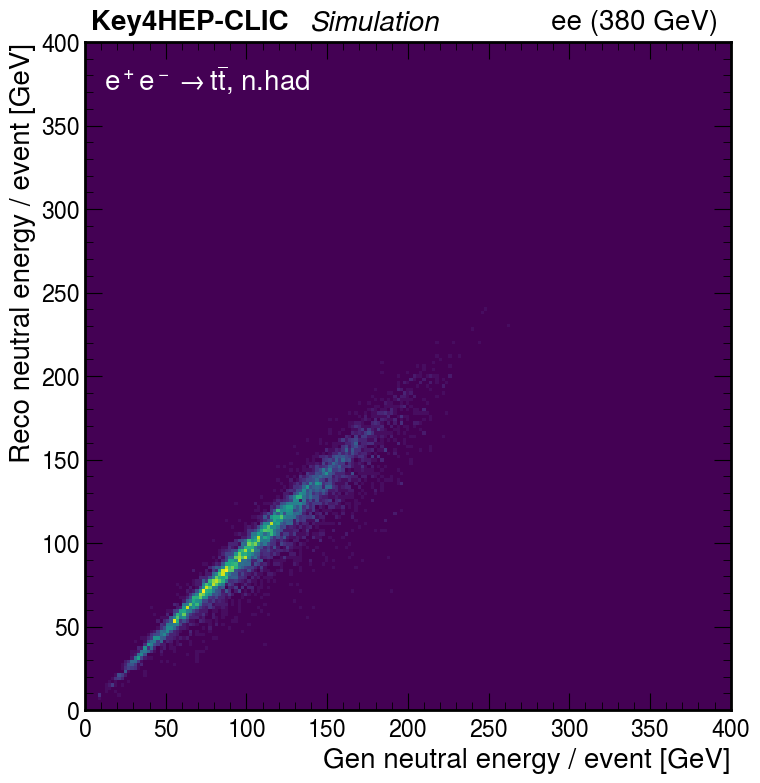

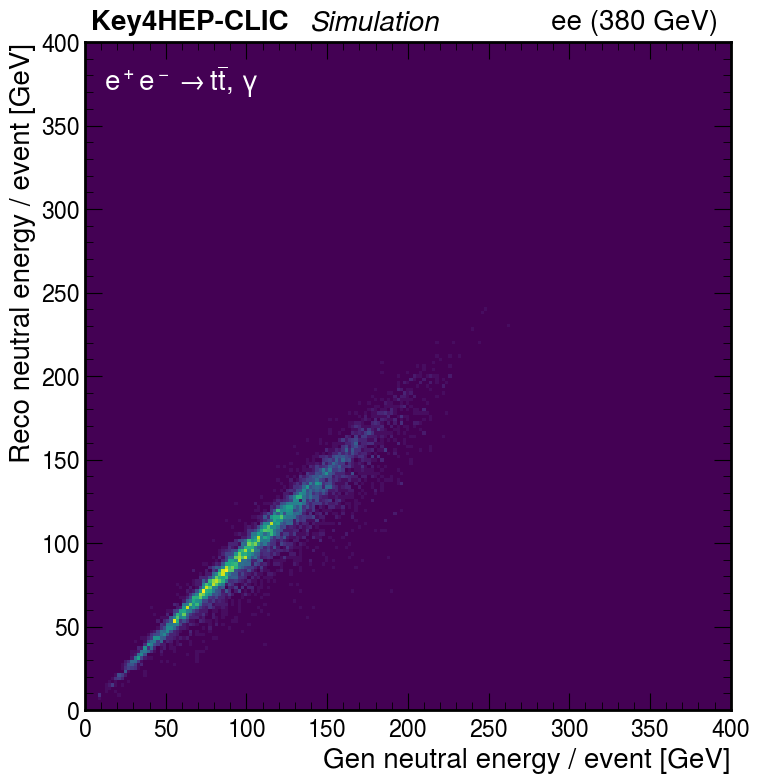

In [37]:
for cls_id in [2, 3]:

    sum_neutral_energy = {}
    sum_neutral_energy["Gen"], sum_neutral_energy["Cand"] = [], []

    for i, batch in enumerate(test_list[sample]):
        ycand = unpack_target(batch.ygen)
        ygen = unpack_target(batch.ycand)

        msk_gen_id = (ygen["cls_id"] == 2) | (ygen["cls_id"] == 3)
        msk = msk_gen_id & ((ycand["cls_id"] != 0))

        sum_neutral_energy["Gen"] += (ygen["energy"] * msk).sum(axis=1)
        sum_neutral_energy["Cand"] += (ycand["energy"] * msk).sum(axis=1)

    fig, ax = plt.subplots(figsize=(8,8))

    ax.hist2d(
        sum_neutral_energy["Gen"],
        sum_neutral_energy["Cand"],
        bins=np.linspace(0,400,200)
    )

    ax.set_xlabel("Gen neutral energy / event [GeV]")
    ax.set_ylabel("Reco neutral energy / event [GeV]")

    sample_label(ax, sample, ", " + CLASS_NAMES_CLIC[cls_id], c="white")
    clic_label(ax)

    plt.tight_layout()    
    plt.savefig(f"{outdir}/neutral_energy_cls{cls_id}_2dcorrelation.pdf")        

# Particles

In [38]:
y = {}
y["Gen"], y["Cand"] = {}, {}
for feat in Y_FEATURES:
    y["Gen"][feat], y["Cand"][feat] = [], []

for i, batch in enumerate(test_list[sample]):
    ygen = unpack_target(batch.ygen)
    ycand = unpack_target(batch.ycand)
    
    for feat in Y_FEATURES:
        y["Gen"][feat] += ygen[feat].reshape(-1).tolist()
        y["Cand"][feat] += ycand[feat].reshape(-1).tolist()

In [39]:
for feat in Y_FEATURES:
    y["Gen"][feat] = np.array(y["Gen"][feat])
    y["Cand"][feat] = np.array(y["Cand"][feat])

## 2d-correlation plots

/tmp/ipykernel_8250/2483658820.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,8))


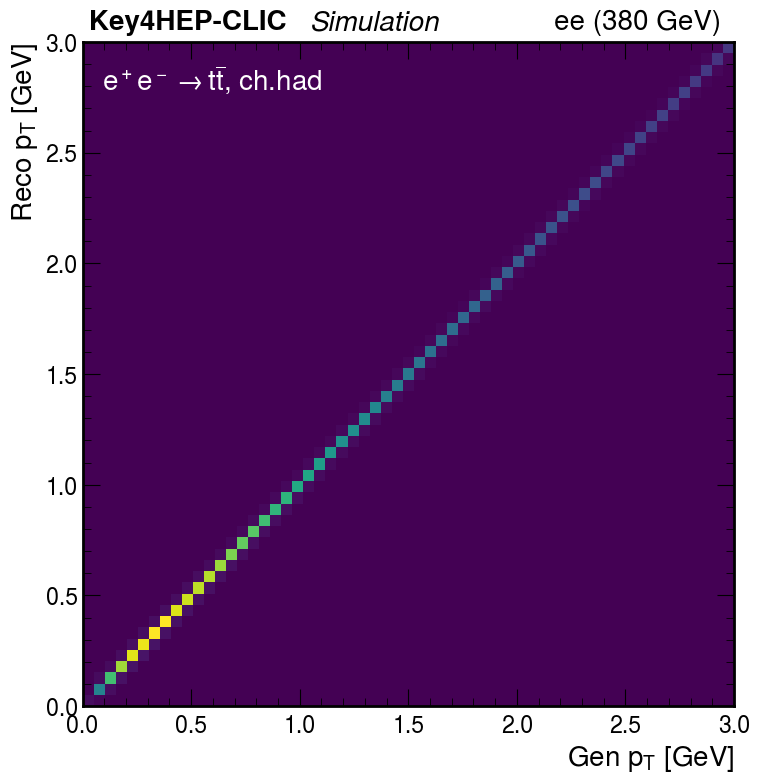

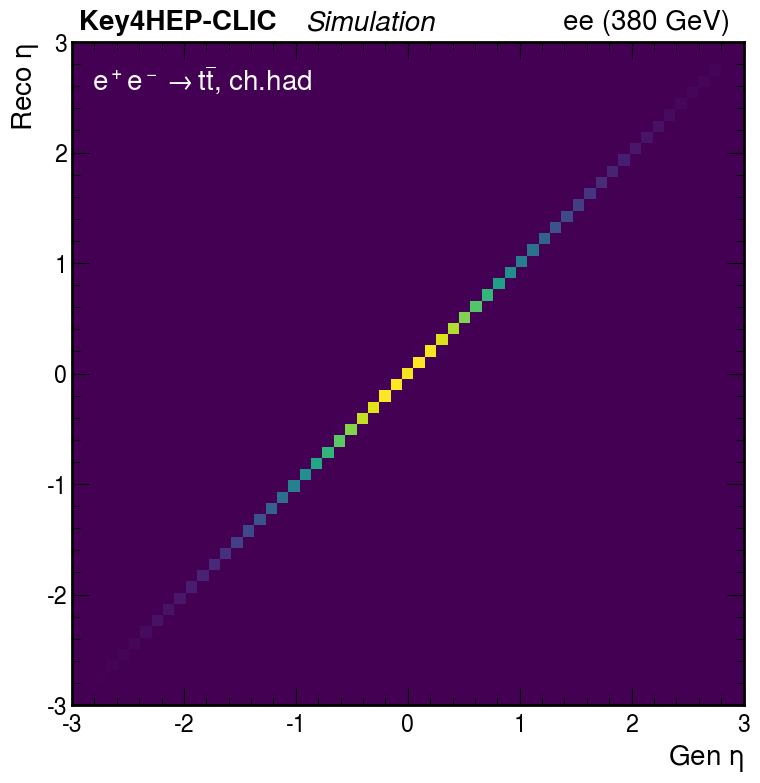

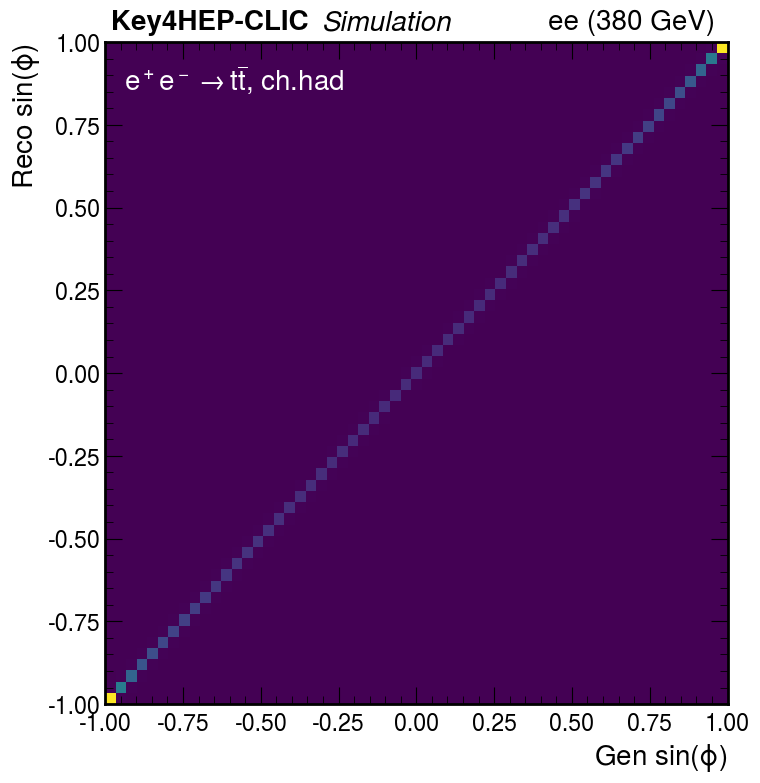

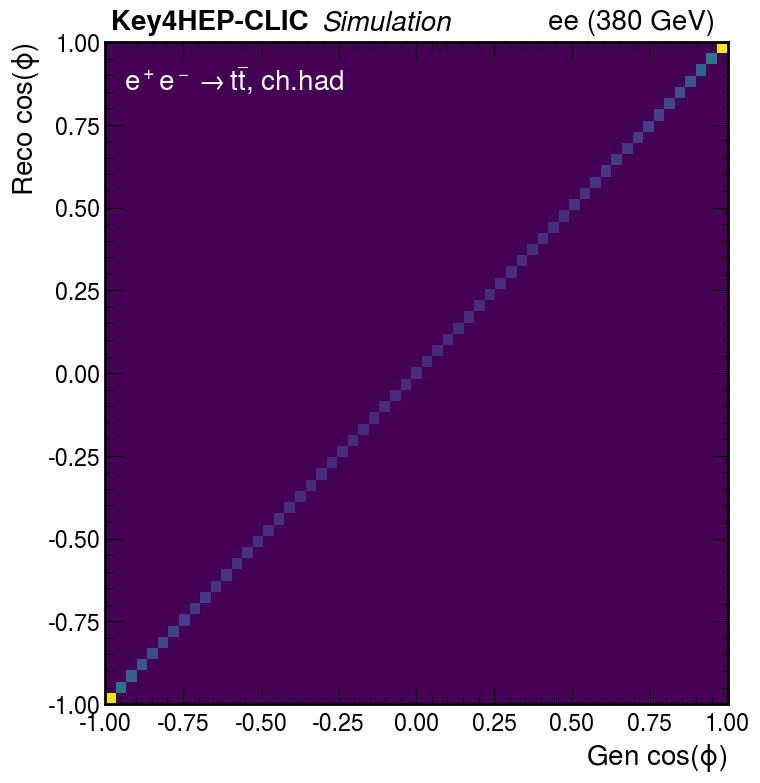

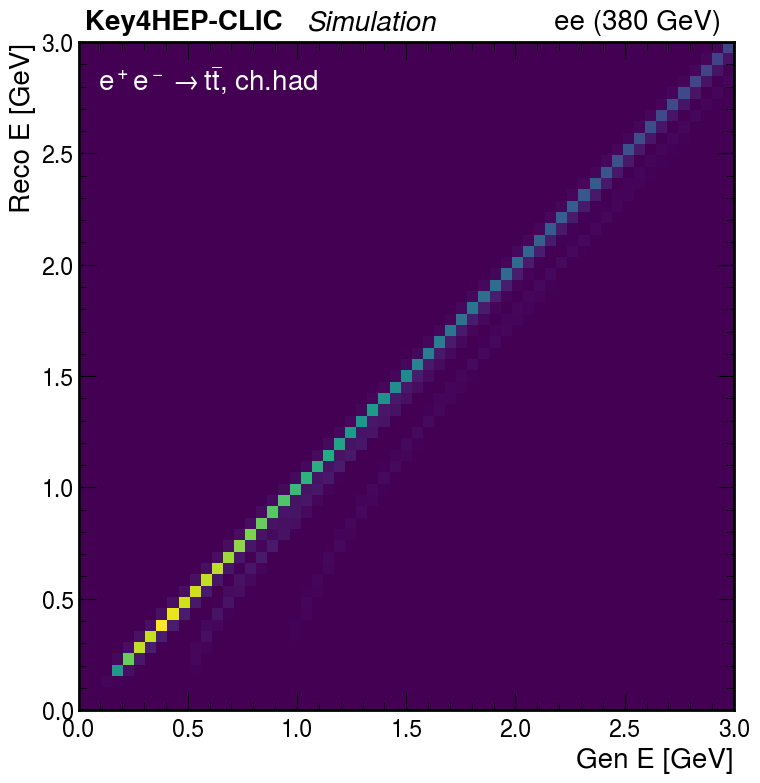

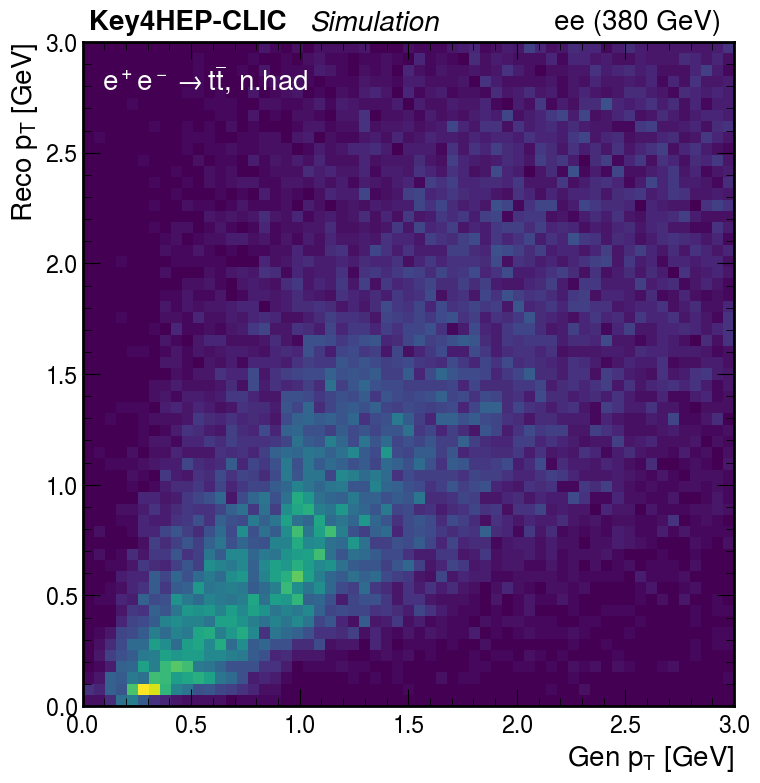

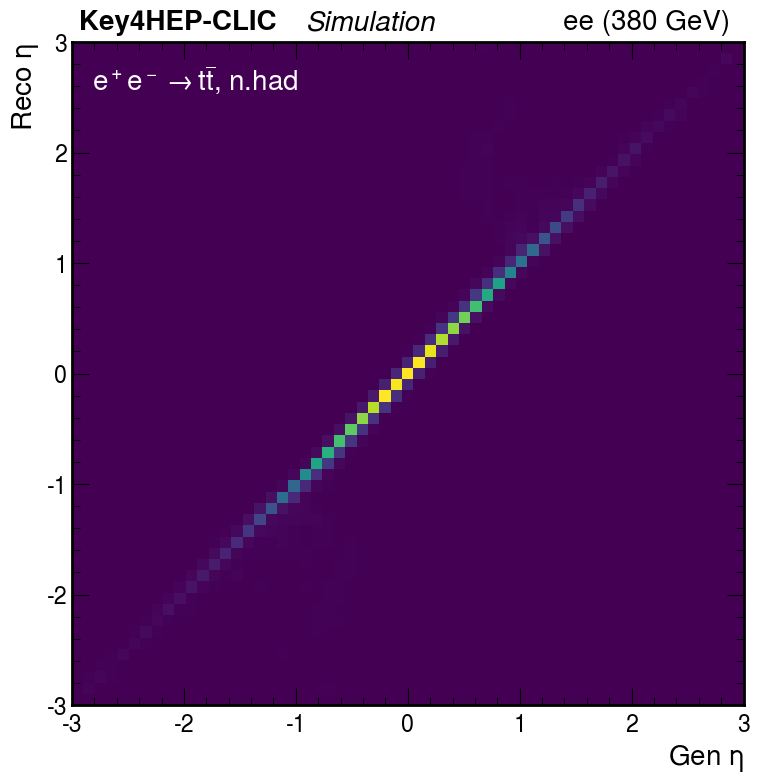

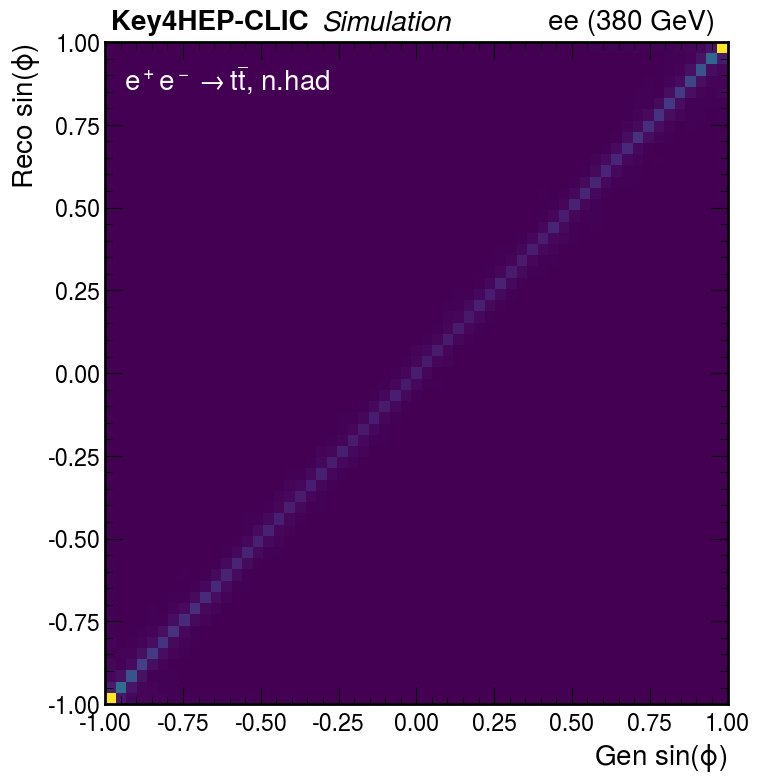

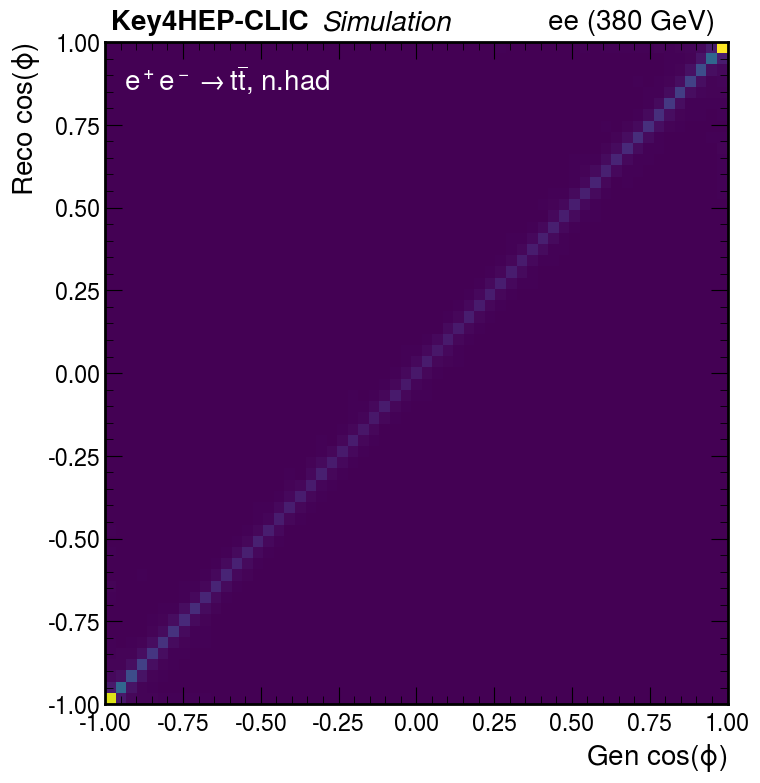

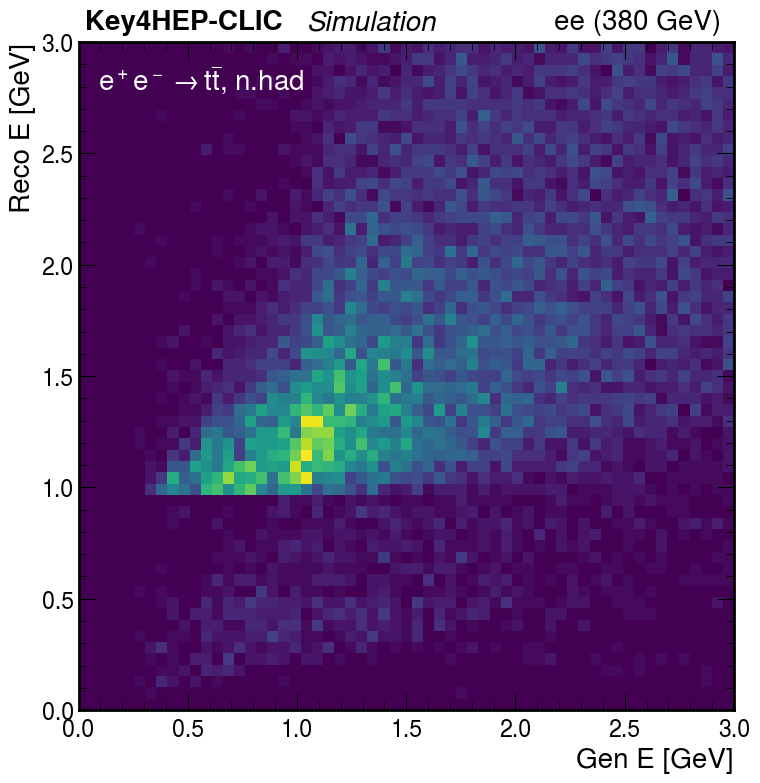

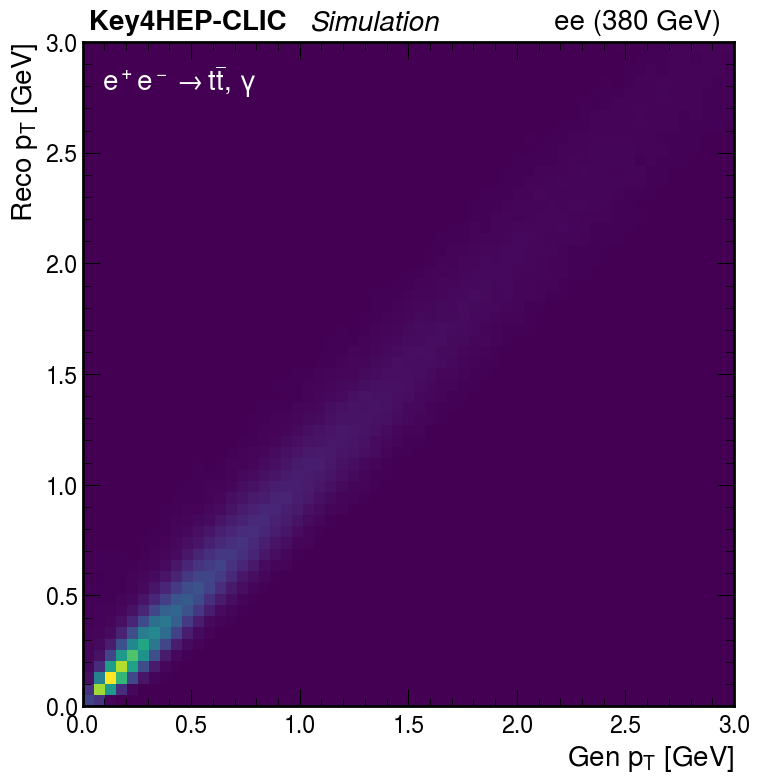

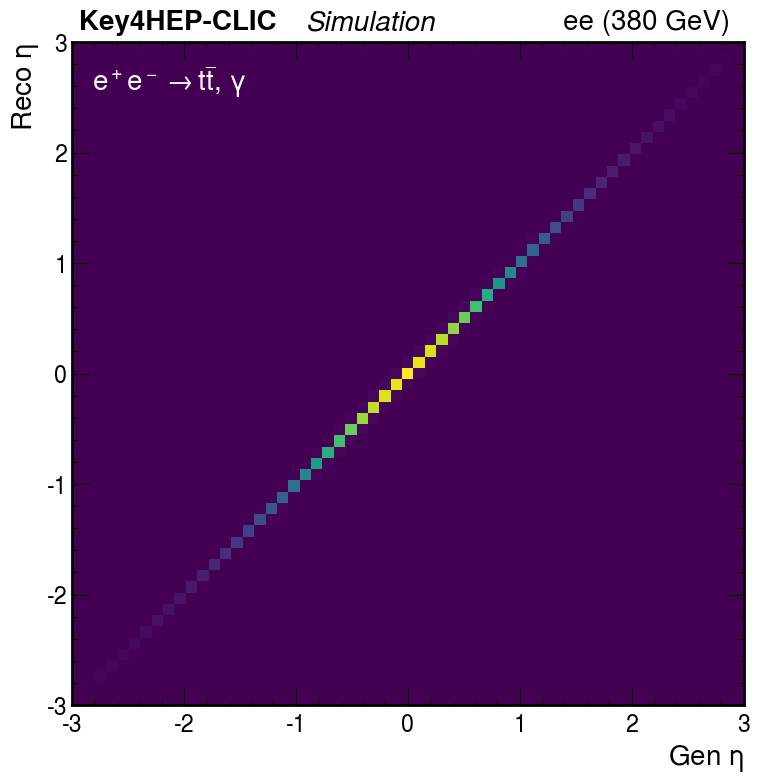

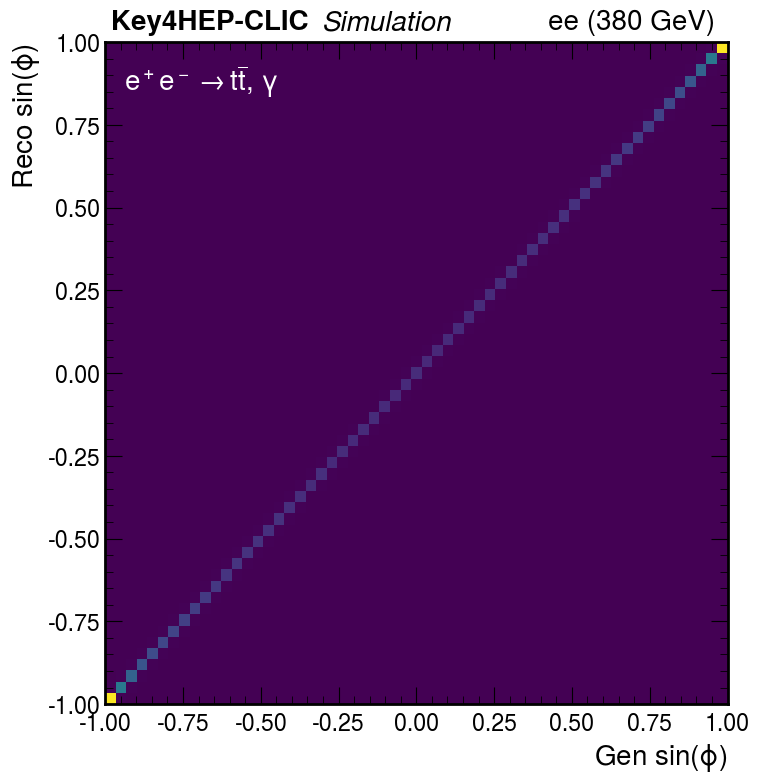

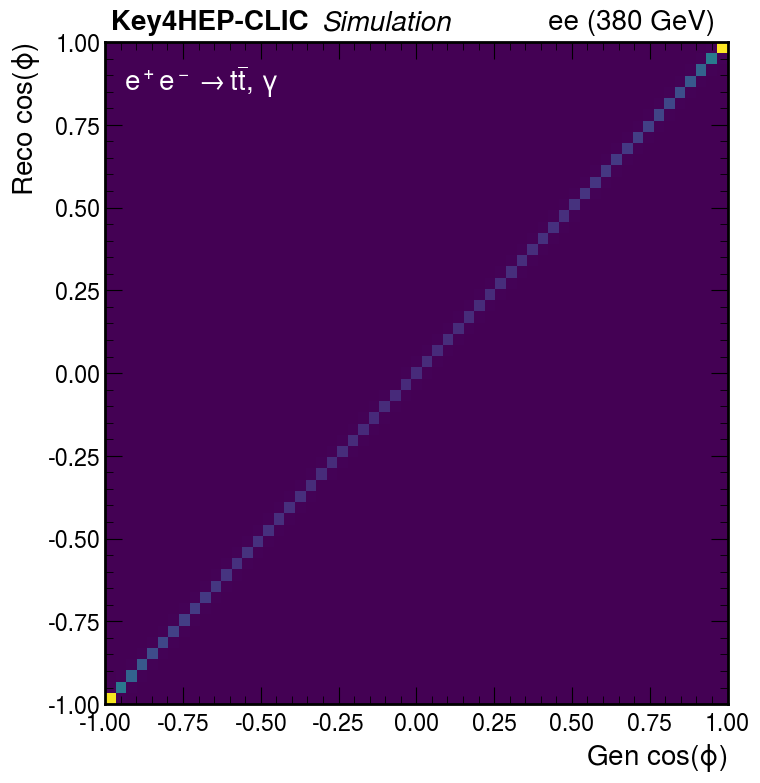

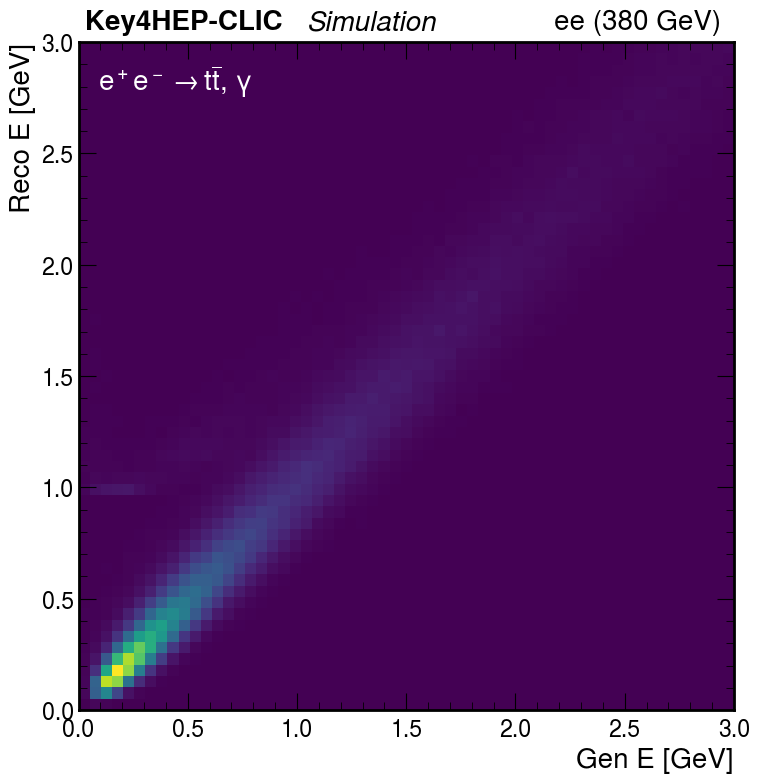

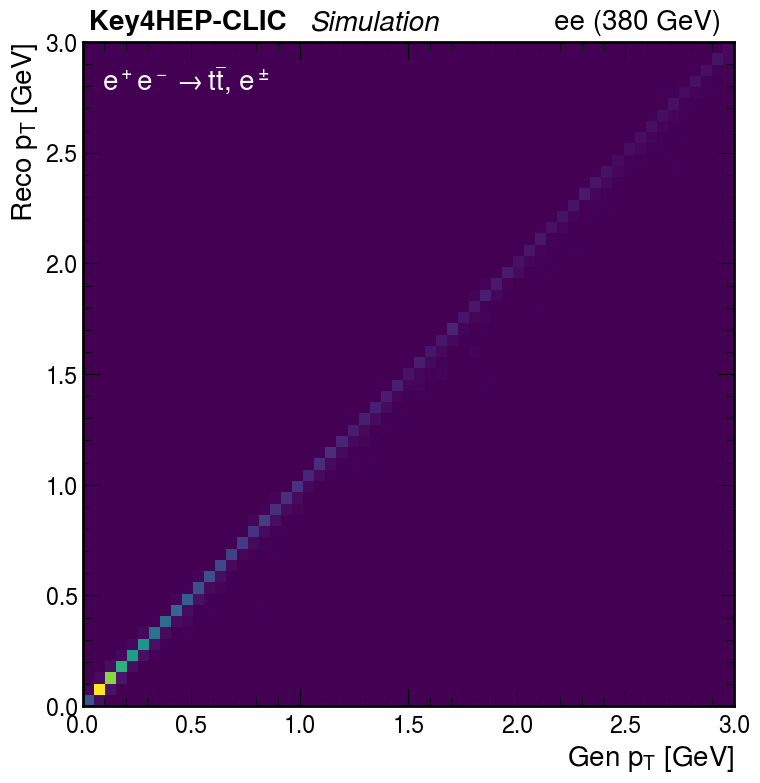

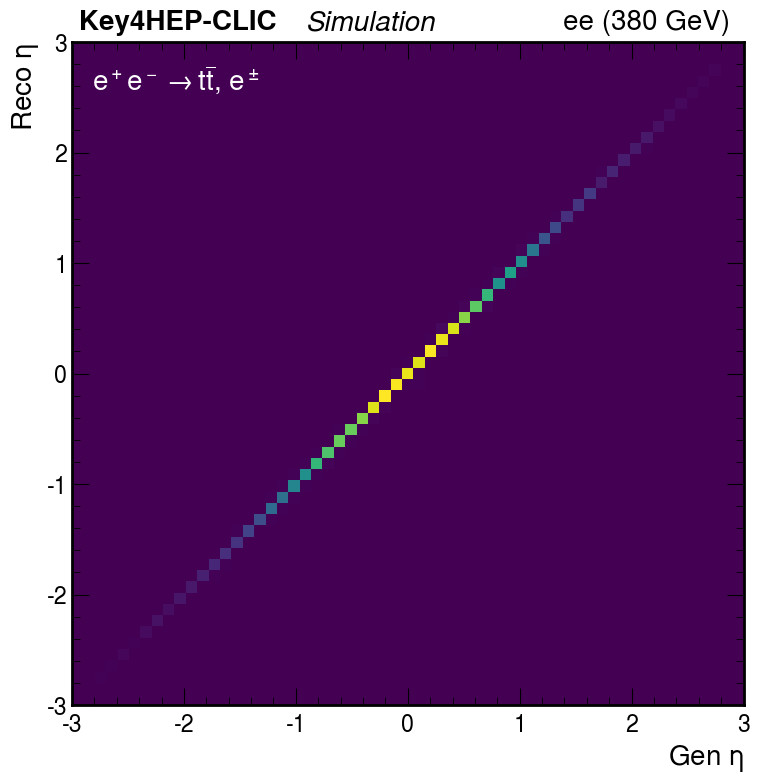

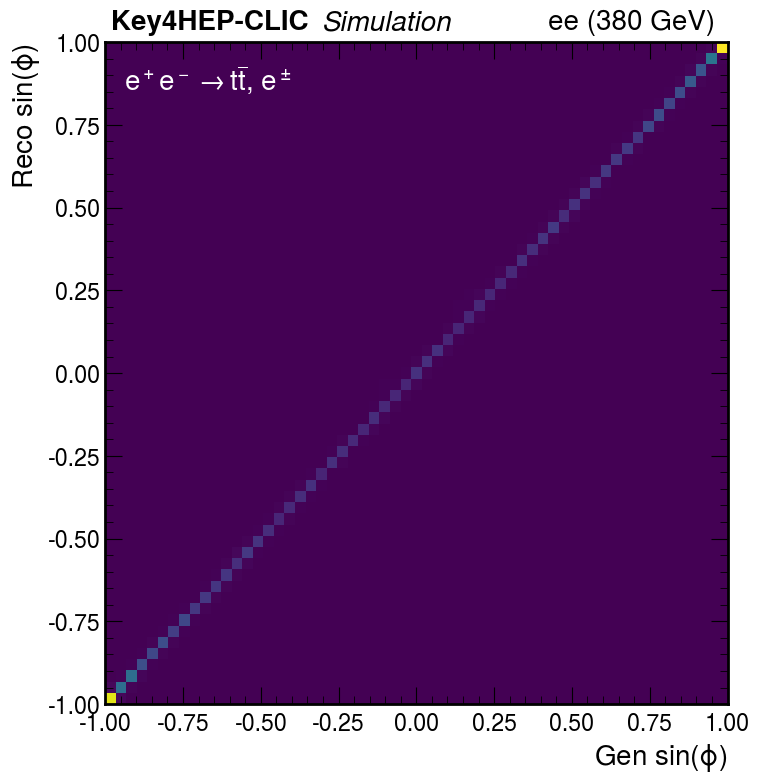

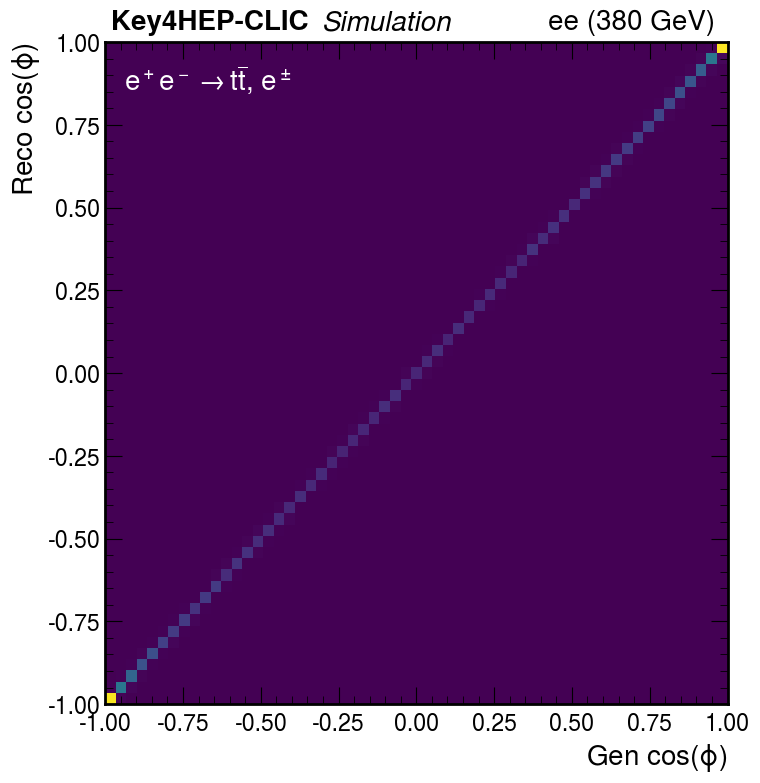

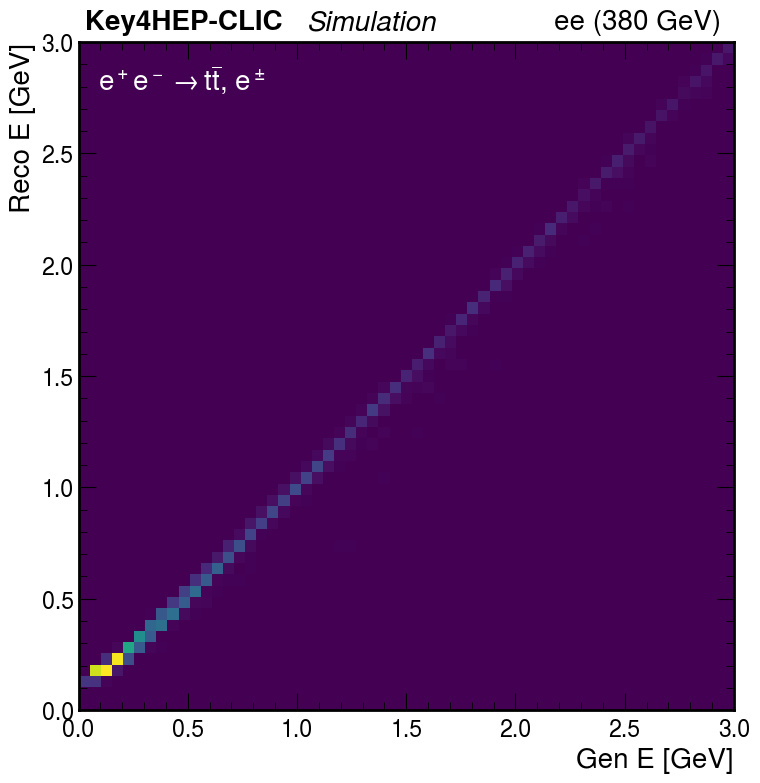

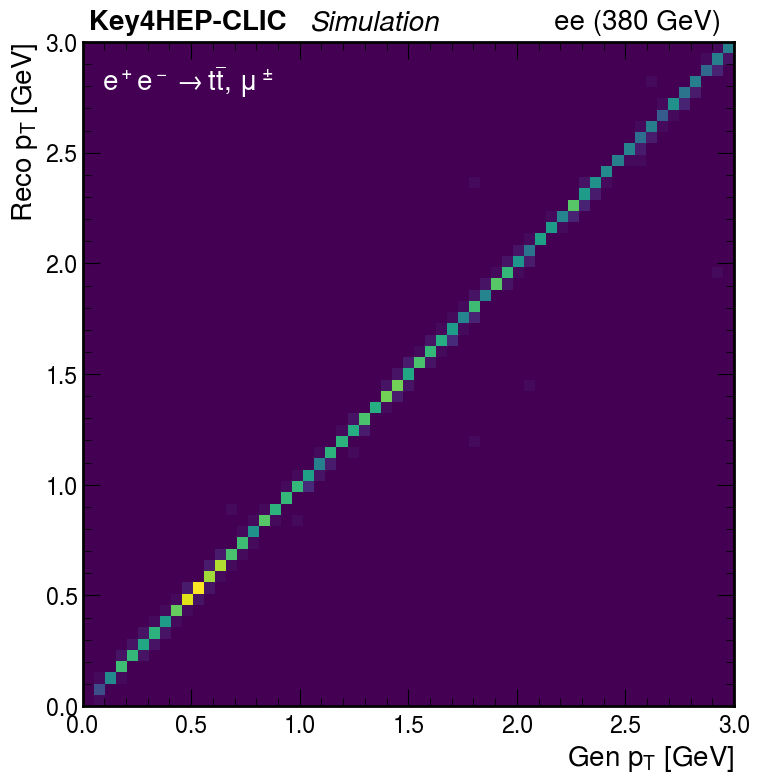

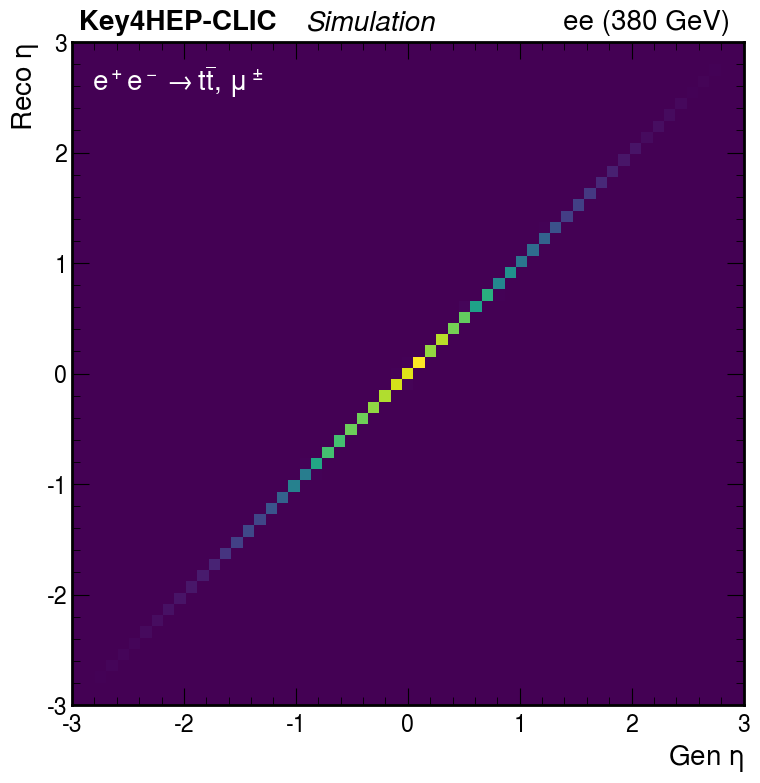

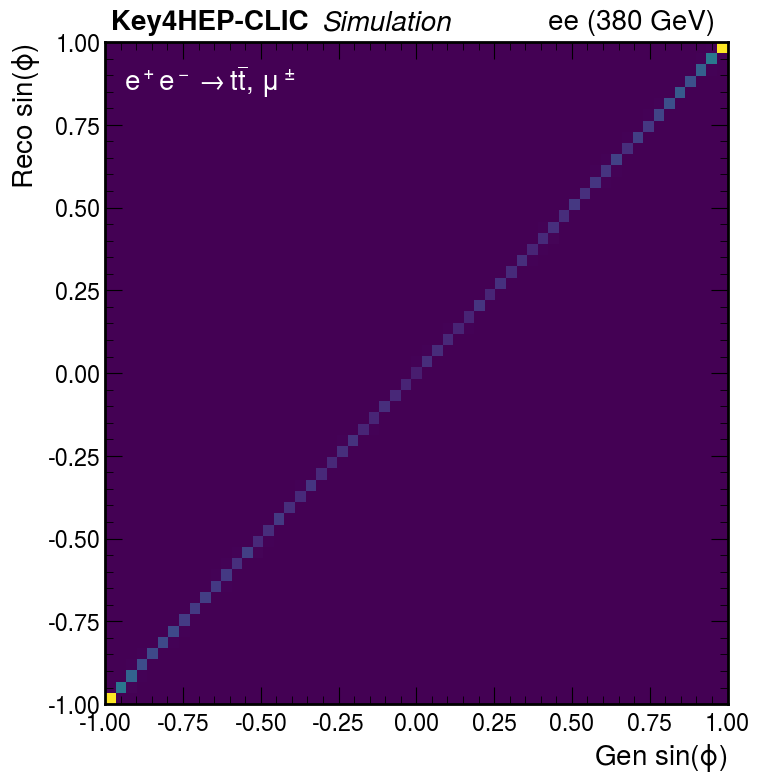

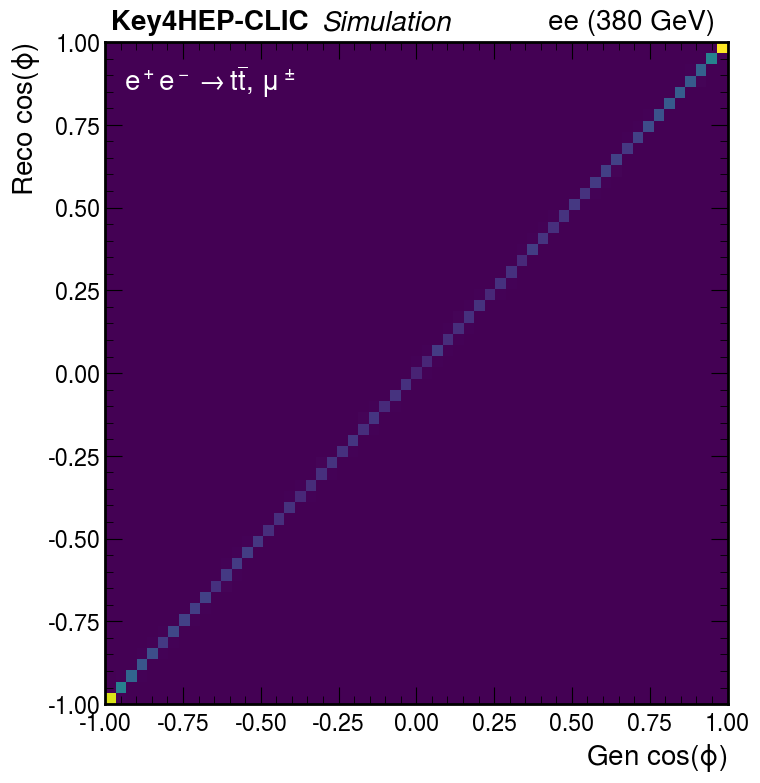

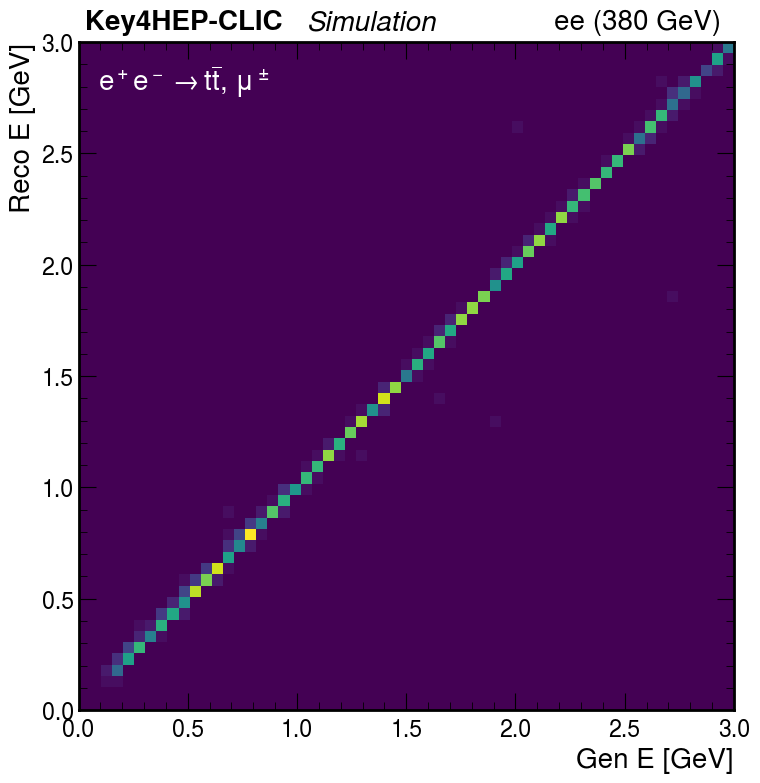

In [40]:
binning_dict = {
    "pt": np.linspace(0,3,60),
    "eta": np.linspace(-3,3,60),
    "sin_phi": np.linspace(-1,1,60),
    "cos_phi": np.linspace(-1,1,60),
    "energy": np.linspace(0,3,60),    
}

for cls_id in [
    1, 
    2, 
    3, 
    4, 
    5,
]:
    msk_gen_id = y["Gen"]["cls_id"] == cls_id
    msk = msk_gen_id & (y["Cand"]["cls_id"] != 0)

    for feat in ["pt", "eta", "sin_phi", "cos_phi", "energy"]:

        fig, ax = plt.subplots(figsize=(8,8))

        ax.hist2d(
            y["Gen"][feat][msk],
            y["Cand"][feat][msk],
            bins=binning_dict[feat]
        )

        ax.set_xlabel("Gen " + FEAT_NAMES_CLIC[feat])
        ax.set_ylabel("Reco "+ FEAT_NAMES_CLIC[feat])

        sample_label(ax, sample, ", " + CLASS_NAMES_CLIC[cls_id], c="white")
        clic_label(ax)

        plt.tight_layout()        
        plt.savefig(f"{outdir}/cls{cls_id}_2dcorrelation_{feat}.pdf")

# 1d-distributions

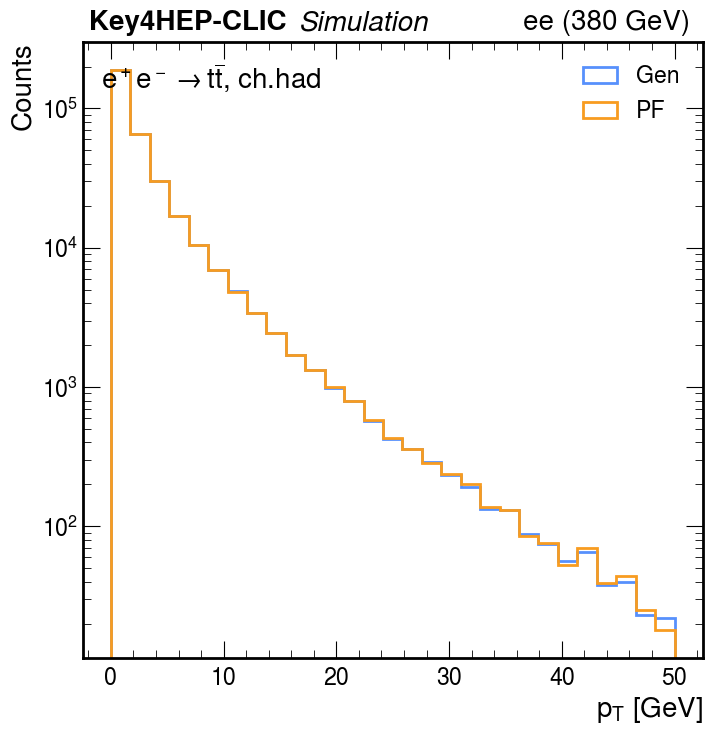

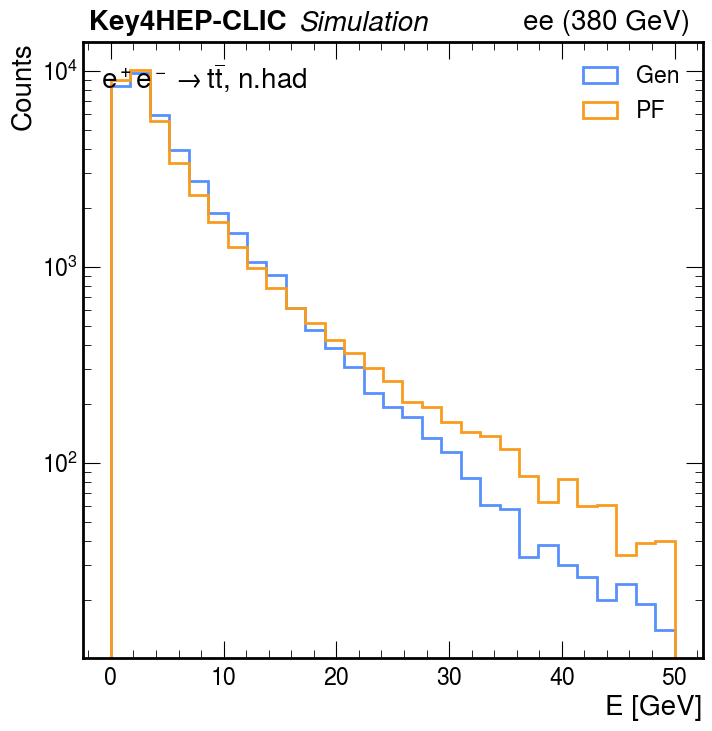

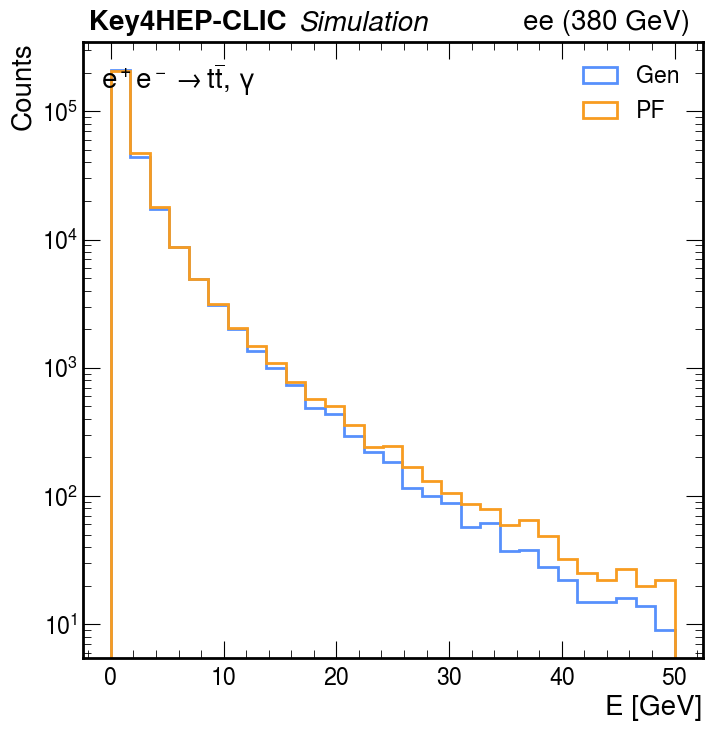

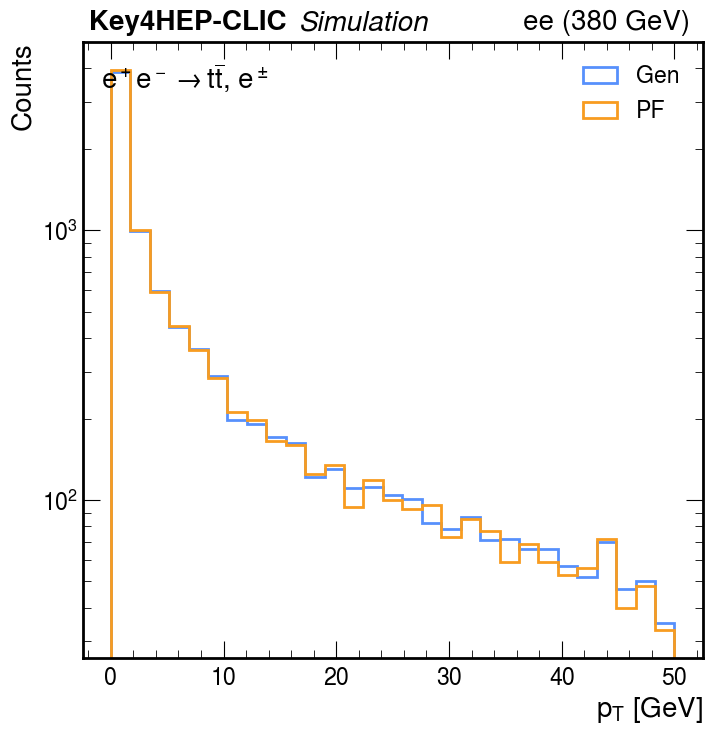

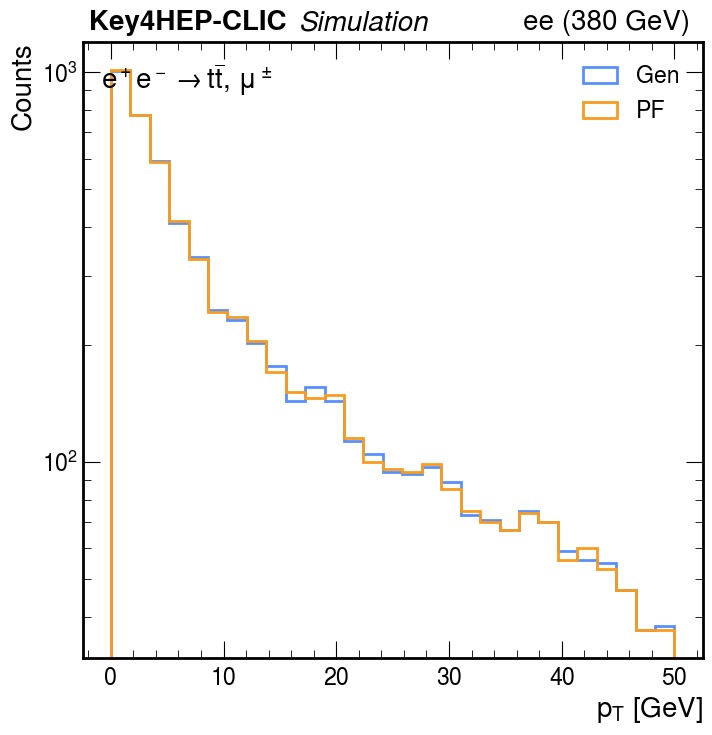

In [45]:
# convention is (pdgid, feat, bins)
plot = [
    (1, "pt", np.linspace(0,50,30)),
    (2, "energy", np.linspace(0,50,30)),
    (3, "energy", np.linspace(0,50,30)),
    (4, "pt", np.linspace(0,50,30)),
    (5, "pt", np.linspace(0,50,30)),
]

##############

for cls_id, feat, bins in plot:
    
    fig, ax = plt.subplots(figsize=(8,8))

    msk_gen_id = y["Gen"]["cls_id"] == cls_id
    msk = msk_gen_id & ((y["Cand"]["cls_id"] != 0))

    X = y["Gen"][feat][msk]
    ax.hist(X, bins=bins, histtype="step", lw=2, label="Gen")    
    
    X = y["Cand"][feat][msk]
    ax.hist(X, bins=bins, histtype="step", lw=2, label="PF")

    ax.legend()

    ax.set_xlabel(f"{FEAT_NAMES_CLIC[feat]}")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")

    sample_label(ax, sample, ", " + CLASS_NAMES_CLIC[cls_id], c="black")
    clic_label(ax)

#     plt.tight_layout()
    plt.savefig(f"{outdir}/1d_cls{cls_id}_{feat}.pdf")

# Gen-Reco association efficiency
https://github.com/jpata/particleflow/blob/main/notebooks/cms/cms-mlpf.ipynb

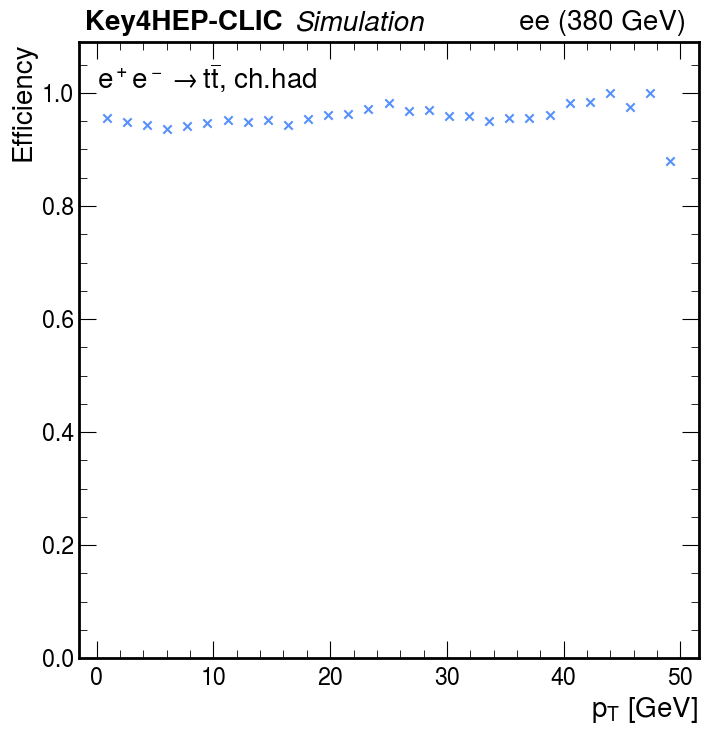

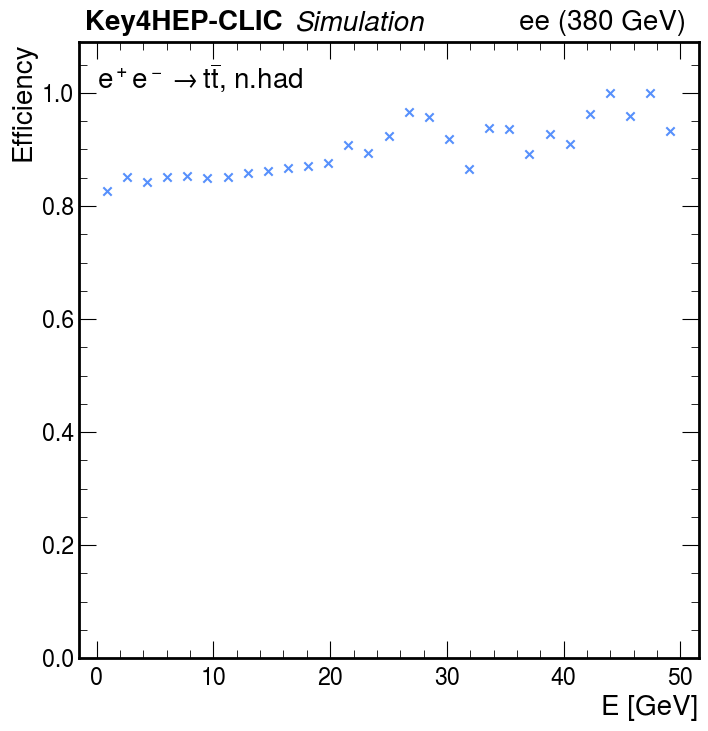

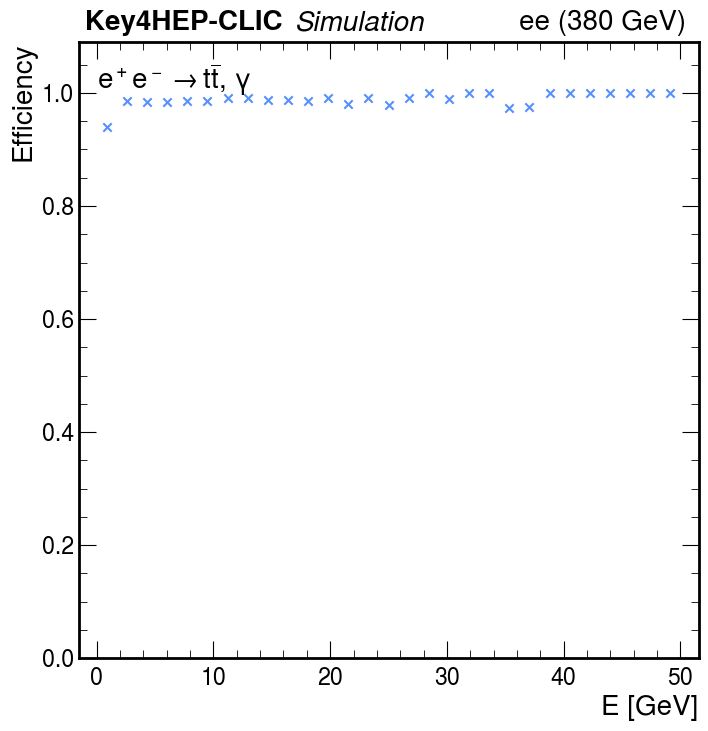

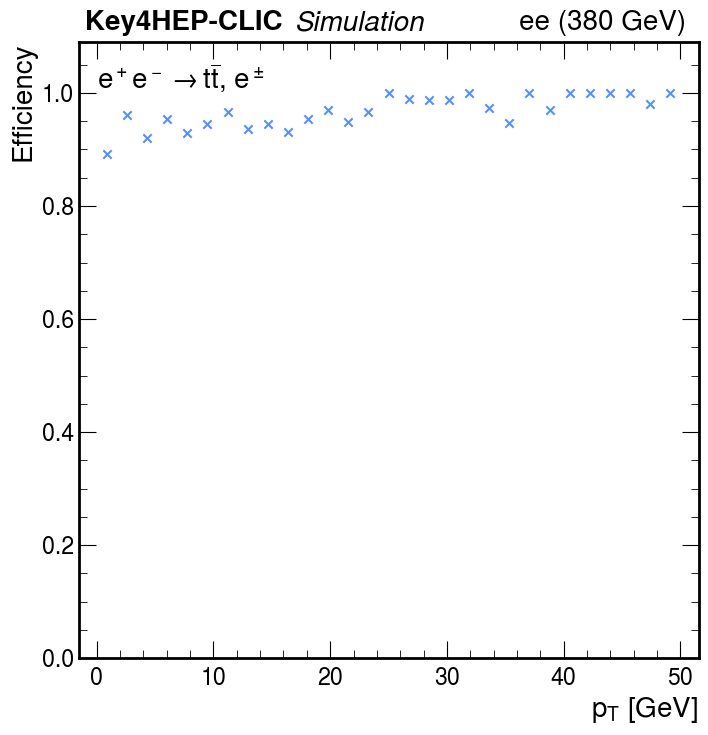

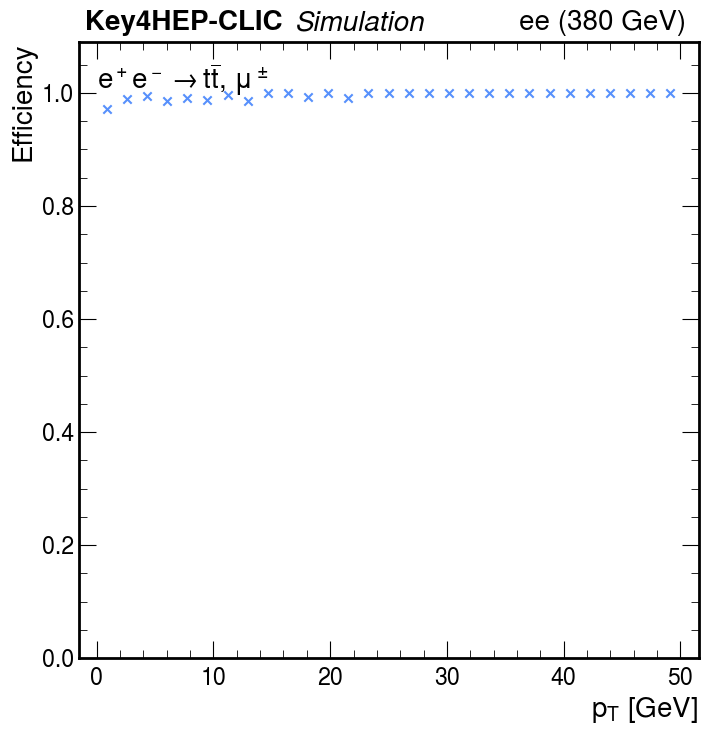

In [42]:
# convention is (pdgid, feat, bins)
plot = [
    (1, "pt", np.linspace(0,50,30)),
    (2, "energy", np.linspace(0,50,30)),
    (3, "energy", np.linspace(0,50,30)),
    (4, "pt", np.linspace(0,50,30)),
    (5, "pt", np.linspace(0,50,30)),
]

##############

for cls_id, feat, bins in plot:

    X = y["Gen"][feat]

    # Genparticle exists, reco particle exists
    Num = X[(y["Gen"]["cls_id"] == cls_id) & (y["Cand"]["cls_id"] != 0)]
    Num_vals, _ = np.histogram(Num, bins=bins)

    # Genparticle exists
    Den = X[y["Gen"]["cls_id"] == cls_id]
    Den_vals, _ = np.histogram(Den, bins=bins)

    ##############

    fig, ax = plt.subplots(figsize=(8,8))

    midpoints = (bins[:-1] + bins[1:]) / 2
    ax.scatter(
        midpoints,
        Num_vals / Den_vals,
        marker="x",
    )

    ax.set_xlabel(f"{FEAT_NAMES_CLIC[feat]}")
    ax.set_ylabel(f"Efficiency")
    ax.set_ylim(0, 1.09)

    sample_label(ax, sample, ", " + CLASS_NAMES_CLIC[cls_id])
    clic_label(ax)
#     plt.tight_layout()

    plt.savefig(f"{outdir}/eff_cls{cls_id}_{feat}.pdf")

# Gen-Reco association fake rate

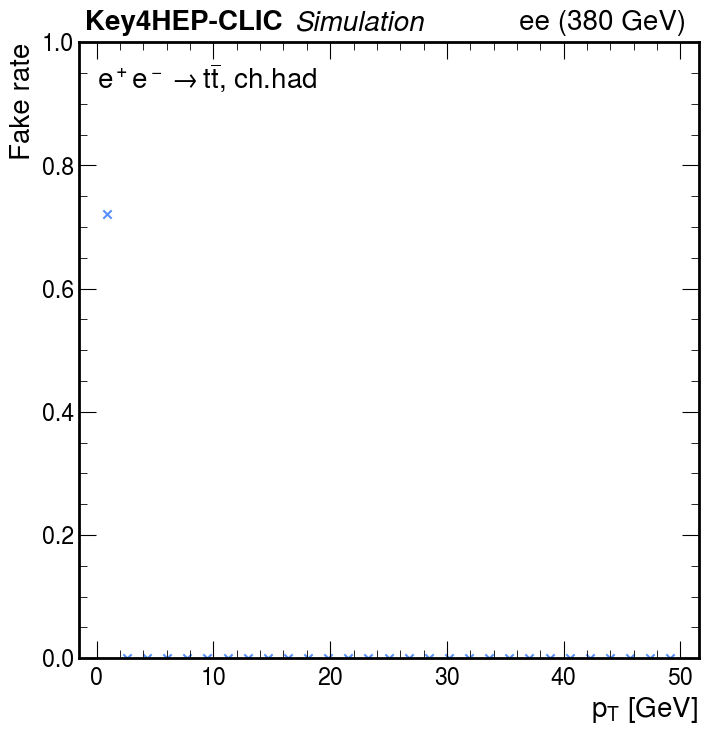

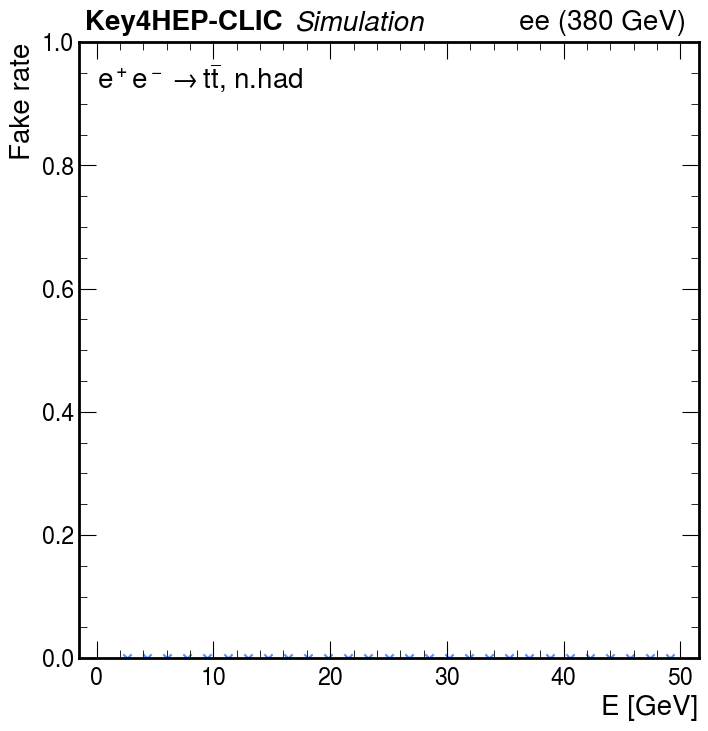

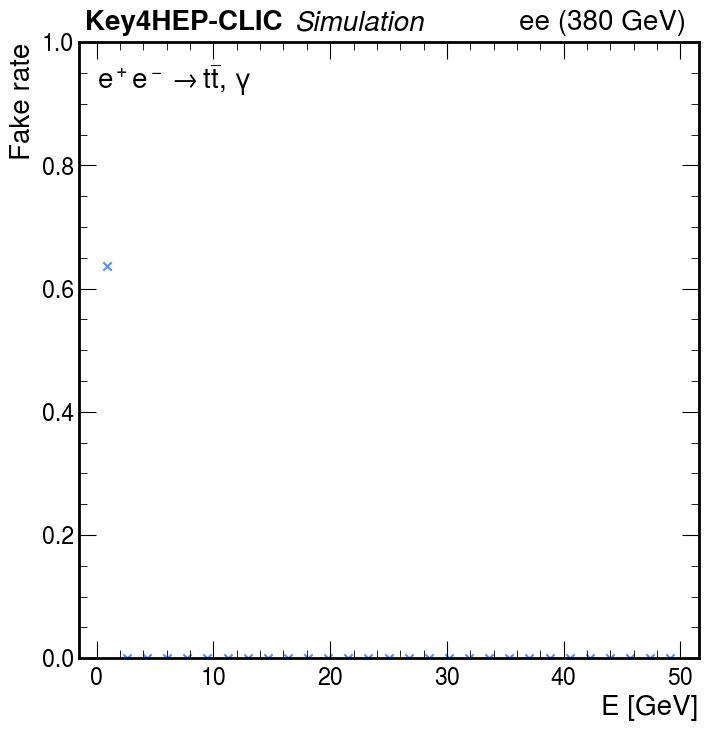

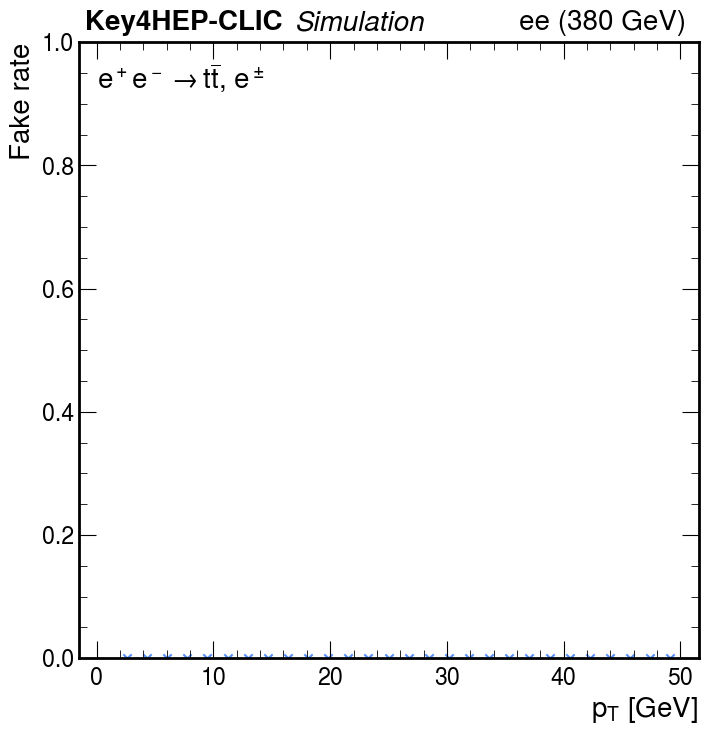

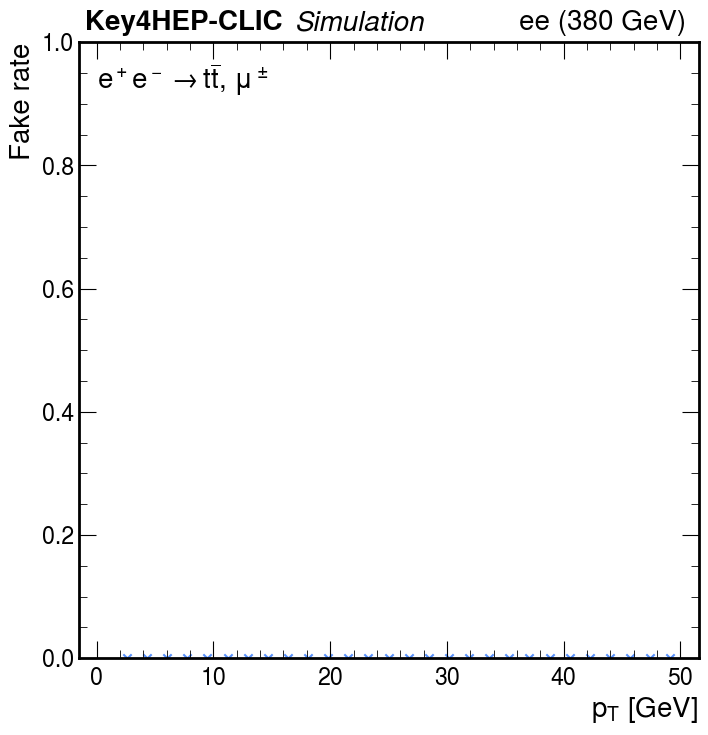

In [46]:
# convention is (pdgid, feat, bins)
plot = [
    (1, "pt", np.linspace(0,50,30)),
    (2, "energy", np.linspace(0,50,30)),
    (3, "energy", np.linspace(0,50,30)),
    (4, "pt", np.linspace(0,50,30)),
    (5, "pt", np.linspace(0,50,30)),
]

for cls_id, feat, bins in plot:

    X = y["Gen"][feat]

    # Genparticle does not exist, reco particle exists
    Num = X[(y["Gen"]["cls_id"] == 0) & (y["Cand"]["cls_id"] != 0)]
    Num_vals, _ = np.histogram(Num, bins=bins)

    # Genparticle exists
    Den = X[y["Gen"]["cls_id"] == cls_id]
    Den_vals, _ = np.histogram(Den, bins=bins)

    ##############

    fig, ax = plt.subplots(figsize=(8,8))

    midpoints = (bins[:-1] + bins[1:]) / 2
    ax.scatter(
        midpoints,
        Num_vals / Den_vals,
        marker="x",
    )

    ax.set_xlabel(f"{FEAT_NAMES_CLIC[feat]}")
    ax.set_ylabel(f"Fake rate")
    ax.set_ylim(0, 1)

    sample_label(ax, sample, ", " + CLASS_NAMES_CLIC[cls_id])
    clic_label(ax)

#     plt.tight_layout()
    plt.savefig(f"{outdir}/fakerate_cls{cls_id}_{feat}.pdf")    

# Objects (MET and Jets)

## MET

In [47]:
MET = {}
MET["Gen"], MET["Cand"] = [], []

for i, batch in enumerate(test_list[sample]):
    ygen = unpack_target(batch.ygen)
    ycand = unpack_target(batch.ycand)

    ####################### MET from gen
    msk_gen = (ygen["cls_id"] != 0)
    gen_px = (ygen["pt"] * ygen["cos_phi"]) * msk_gen
    gen_py = (ygen["pt"] * ygen["sin_phi"]) * msk_gen
    MET["Gen"] += torch.sqrt(torch.sum(gen_px, axis=1) ** 2 + torch.sum(gen_py, axis=1) ** 2).tolist()
    
    ####################### MET from PFcand
    msk_cand = (ycand["cls_id"] != 0)
    cand_px = (ycand["pt"] * ycand["cos_phi"]) * msk_cand
    cand_py = (ycand["pt"] * ycand["sin_phi"]) * msk_cand
    MET["Cand"] += torch.sqrt(torch.sum(cand_px, axis=1) ** 2 + torch.sum(cand_py, axis=1) ** 2).tolist()  

In [48]:
for key in MET:
    MET[key] = np.array(MET[key])

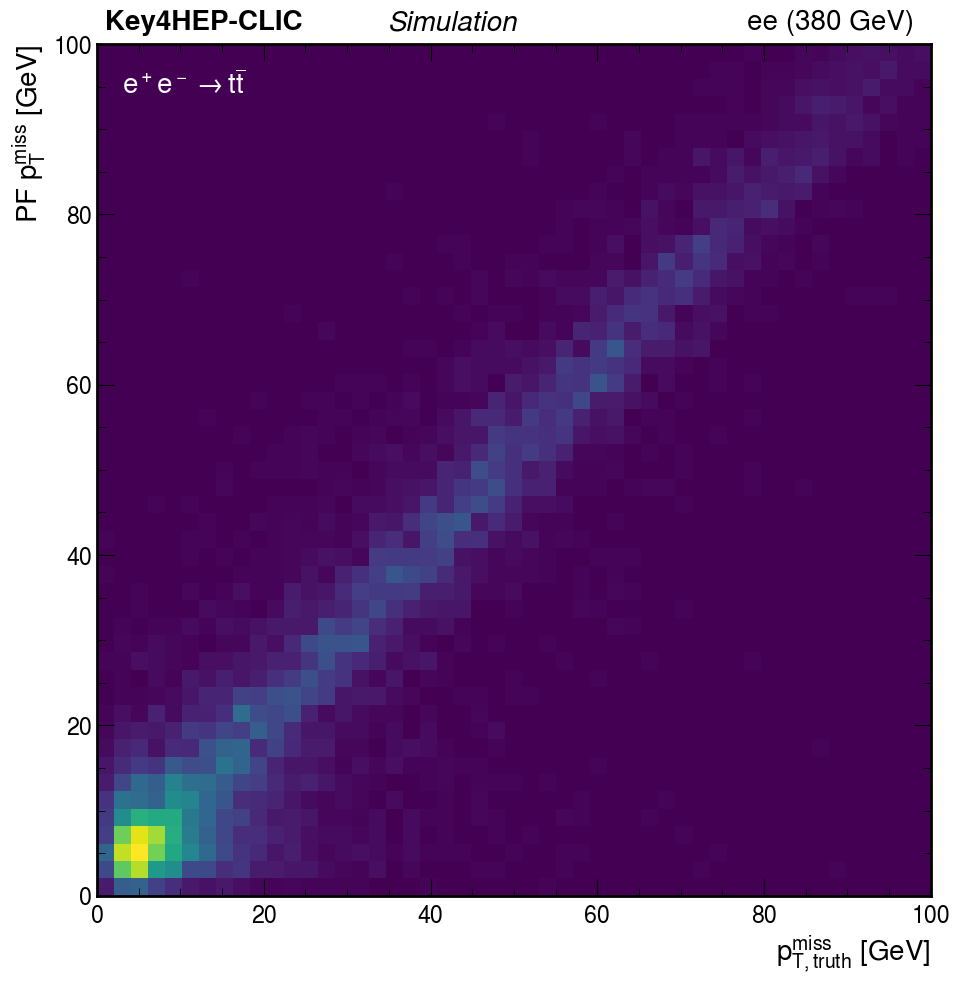

In [50]:
fig, ax = plt.subplots(figsize=(10,10))

ax.hist2d(
    MET["Gen"],
    MET["Cand"],
    bins=np.linspace(0,100,50),
)

ax.set_xlabel(labels["gen_met"])
ax.set_ylabel("PF " + labels["met"])

sample_label(ax, sample, c="white")
clic_label(ax)

plt.tight_layout()

plt.savefig(f"{outdir}/met_2dcorrelation.pdf")

In [52]:
def plot_met_resolution(reco_dict, gen_arr, sample):
    """Copied from here https://github.com/jpata/particleflow/blob/main/mlpf/plotting/plot_utils.py#L1260.
    
    reco_dict [dict]: (key [str] = the label (e.g. PF, MLPF), value [np.array] = the reco values)
    gen_arr [np.array]: the gen values
    sample [str]: dataset label

    """    

    bins = [0, 10, 20, 40, 60, 80, 150]   # atm must be 6 bins for corresponding to the 6 subplots
    
    fig, axs = plt.subplots(2, 3, figsize=(3 * 5, 2 * 5))
    
    x_vals, reco_vals = {}, {}
    
    for reco_label, reco_arr in reco_dict.items():
        x_vals[reco_label], reco_vals[reco_label] = [], []
        
        response = reco_arr/gen_arr

        b = np.linspace(0, 5, 100)

        axs = axs.flatten()
        for ibin in range(len(bins) - 1):
            lim_low = bins[ibin]
            lim_hi = bins[ibin + 1]
            x_vals[reco_label].append(np.mean([lim_low, lim_hi]))

            mask_genjet = (reco_arr > lim_low) & (reco_arr <= lim_hi)
            subsample = response[mask_genjet]
            if len(subsample) > 0:
                reco_p25 = np.percentile(subsample, 25)
                reco_p50 = np.percentile(subsample, 50)
                reco_p75 = np.percentile(subsample, 75)
            else:
                reco_p25 = 0
                reco_p50 = 0
                reco_p75 = 0
            reco_vals[reco_label].append([reco_p25, reco_p50, reco_p75])

            plt.sca(axs[ibin])
            plt.hist(subsample, bins=b, histtype="step", lw=2, label=reco_label)
            plt.ylabel("Events / bin")
            plt.xlabel(labels["reco_gen_met_ratio"])
            plt.axvline(1.0, ymax=0.7, color="black", ls="--")
            plt.legend(loc=1, fontsize=16)
            plt.title(labels["gen_met_range"].format(lim_low, lim_hi))
            plt.yscale("log")

        x_vals[reco_label] = np.array(x_vals[reco_label])
        reco_vals[reco_label] = np.array(reco_vals[reco_label])
            
    plt.tight_layout()
    plt.savefig(f"{outdir}/met_response_binned.pdf")

    # Plot Median of gen pt
    plt.figure(figsize=(8,8))    
    ax = plt.gca()
    for reco_label in reco_dict:
        plt.plot(x_vals[reco_label], reco_vals[reco_label][:, 1], marker="o", label=reco_label)
    plt.legend(loc=1, fontsize=16)
    plt.ylabel("Response median")
    plt.xlabel(labels["gen_met"])
    plt.axhline(1.0, color="black", ls="--", lw=0.5)
    sample_label(ax, sample)
    clic_label(ax)
#     plt.tight_layout()    
    plt.savefig(f"{outdir}/met_response_M.pdf")    

    # Plot IQR/M as a function of gen pt    
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    for reco_label in reco_dict:
        plt.plot(x_vals[reco_label], (reco_vals[reco_label][:, 2] - reco_vals[reco_label][:, 0]) / reco_vals[reco_label][:, 1], marker="o", label=reco_label)
    plt.legend(loc=1, fontsize=16)
    plt.ylabel("Response IQR / median")
    plt.xlabel(labels["gen_met"])
    sample_label(ax, sample)
    clic_label(ax)
#     plt.tight_layout()    
    plt.savefig(f"{outdir}/met_response_iqr.pdf")    

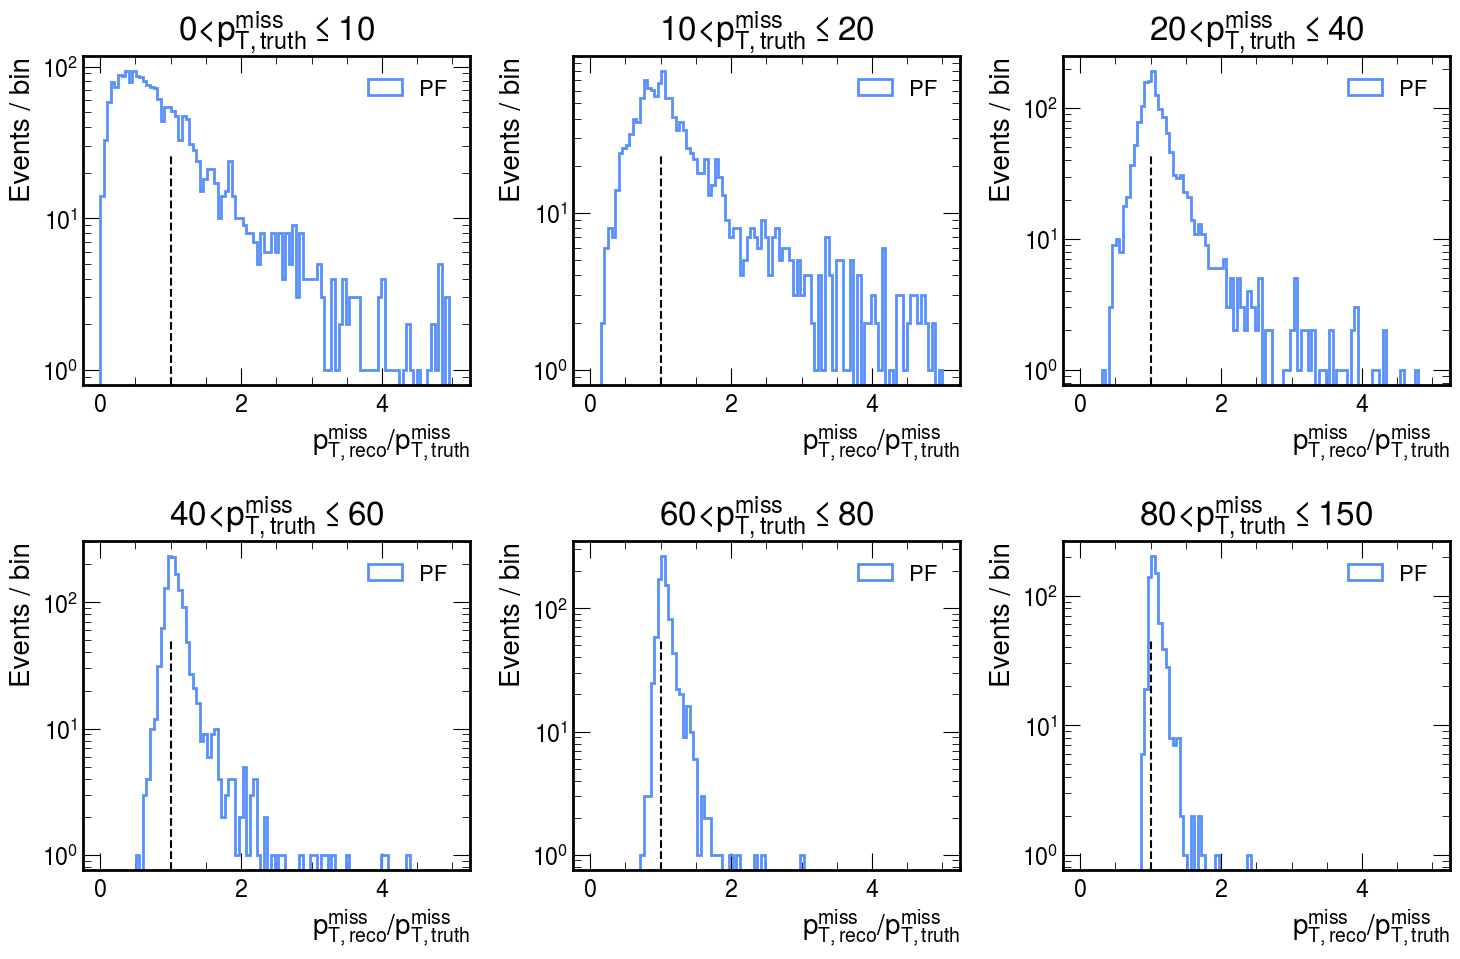

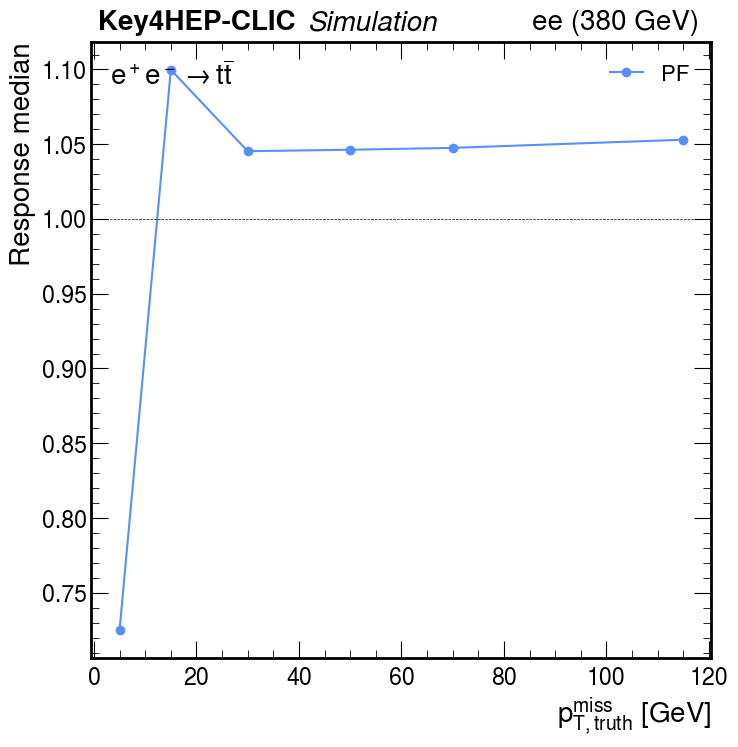

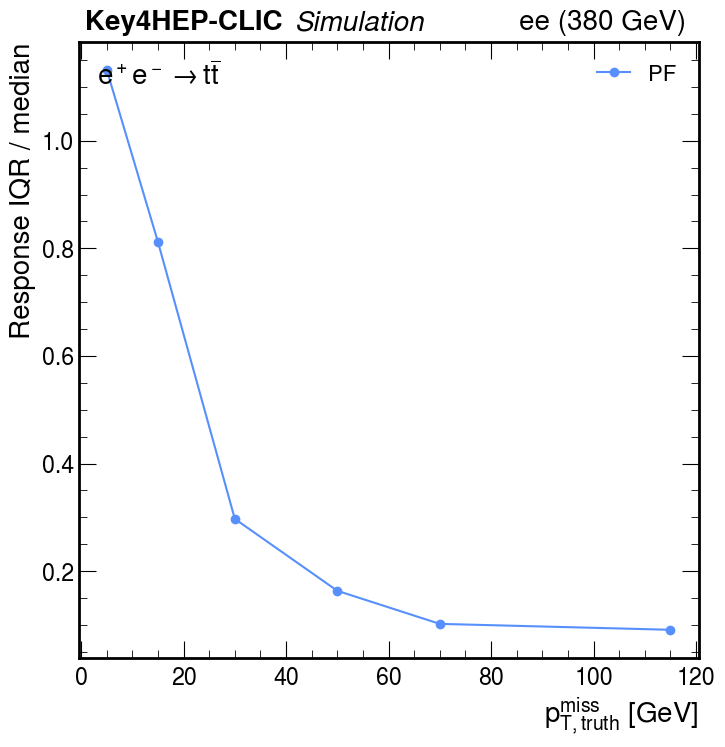

In [53]:
reco_dict = {    
    "PF": MET["Cand"],
}

plot_met_resolution(reco_dict, MET["Gen"], sample)

## Jets

In [54]:
import awkward, vector, fastjet

from jet_utils import build_dummy_array, match_two_jet_collections

### Step 1. Process jets and save into parquets

In [61]:
jetdef = fastjet.JetDefinition(fastjet.ee_genkt_algorithm, 0.7, -1.0)
jet_ptcut = 15.0
jet_match_dr = 0.1

for i, batch in enumerate(test_list[sample]):
    ygen = unpack_target(batch.ygen)
    ycand = unpack_target(batch.ycand)

    X = batch.X[batch.mask].cpu().contiguous().numpy()
    for k, v in ygen.items():
        ygen[k] = v[batch.mask].detach().cpu().contiguous().numpy()
    for k, v in ycand.items():
        ycand[k] = v[batch.mask].detach().cpu().contiguous().numpy()

    # loop over the batch to disentangle the events
    jets_coll = {}

    counts = torch.sum(batch.mask, axis=1).cpu().numpy()
    Xs = awkward.unflatten(awkward.from_numpy(X), counts)

    for typ, ydata in zip(["gen", "cand"], [ygen, ycand]):
        clsid = awkward.unflatten(ydata["cls_id"], counts)
        msk = clsid != 0
        p4 = awkward.unflatten(ydata["p4"], counts)
        vec = vector.awk(
            awkward.zip(
                {
                    "pt": p4[msk][:, :, 0],
                    "eta": p4[msk][:, :, 1],
                    "phi": p4[msk][:, :, 2],
                    "e": p4[msk][:, :, 3],
                }
            )
        )
        cluster = fastjet.ClusterSequence(vec.to_xyzt(), jetdef)
        jets_coll[typ] = cluster.inclusive_jets(min_pt=jet_ptcut)

    gen_to_cand = match_two_jet_collections(jets_coll, "gen", "cand", jet_match_dr)

    matched_jets = awkward.Array({"gen_to_cand": gen_to_cand})

    awkvals = {}
    for flat_arr, typ in [(ygen, "gen"), (ycand, "cand")]:
        awk_arr = awkward.Array({k: flat_arr[k] for k in flat_arr.keys()})
        counts = torch.sum(batch.mask, axis=1).cpu().numpy()
        awkvals[typ] = awkward.unflatten(awk_arr, counts)

        
    outfile = f"{outdir}/jets_parquets/pred_{rank}_{i}.parquet"        
    awkward.to_parquet(
        awkward.Array(
            {
                "inputs": Xs,
                "particles": awkvals,
                "jets": jets_coll,
                "matched_jets": matched_jets,
            }
        ),
        outfile,
    )
#     break

SyntaxError: unterminated string literal (detected at line 51) (2202092746.py, line 51)

### Step 2. Load the jets to make plots

In [55]:
! ls /pfvol/plots_foundation_model/CLD_validation

cld_edm_ttbar_pf  cld_edm_ttbar_pf_jets_parquets


In [56]:
def load_eval_data(path, max_files=None):
    yvals = []
    filenames = []
    print("path", path)

    filelist = list(glob.glob(path))
    print(filelist)

    if max_files is not None:
        filelist = filelist[:max_files]

    for fi in tqdm.tqdm(filelist):
        dd = awkward.from_parquet(fi)
        yvals.append(dd)
        filenames.append(fi)

    data = awkward.concatenate(yvals, axis=0)
    X = data["inputs"]

    yvals = {}
    for typ in ["gen", "cand"]:
        for k in data["particles"][typ].fields:
            yvals["{}_{}".format(typ, k)] = data["particles"][typ][k]

    for typ in ["gen", "cand"]:
        # Compute phi, px, py, pz
        yvals[typ + "_phi"] = np.arctan2(yvals[typ + "_sin_phi"], yvals[typ + "_cos_phi"])
        yvals[typ + "_px"] = yvals[typ + "_pt"] * yvals[typ + "_cos_phi"]
        yvals[typ + "_py"] = yvals[typ + "_pt"] * yvals[typ + "_sin_phi"]
        yvals[typ + "_pz"] = yvals[typ + "_pt"] * np.sinh(yvals[typ + "_eta"])

        # Get the jet vectors
        jetvec = vector.awk(data["jets"][typ])
        for k in ["pt", "eta", "phi", "energy"]:
            yvals["jets_{}_{}".format(typ, k)] = getattr(jetvec, k)

    for typ in ["gen", "cand"]:
        for val in ["pt", "eta", "sin_phi", "cos_phi", "energy"]:
            yvals["{}_{}".format(typ, val)] = yvals["{}_{}".format(typ, val)] * (yvals["{}_cls_id".format(typ)] != 0)

    yvals.update(compute_jet_ratio(data, yvals))

    return yvals, X, filenames


def compute_jet_ratio(data, yvals):
    ret = {}

    ret["jet_gen_to_cand_genpt"] = awkward.to_numpy(
        awkward.flatten(
            vector.awk(data["jets"]["gen"][data["matched_jets"]["gen_to_cand"]["gen"]]).pt,
            axis=1,
        )
    )
    ret["jet_gen_to_cand_geneta"] = awkward.to_numpy(
        awkward.flatten(
            vector.awk(data["jets"]["gen"][data["matched_jets"]["gen_to_cand"]["gen"]]).eta,
            axis=1,
        )
    )
    ret["jet_gen_to_cand_candpt"] = awkward.to_numpy(
        awkward.flatten(
            vector.awk(data["jets"]["cand"][data["matched_jets"]["gen_to_cand"]["cand"]]).pt,
            axis=1,
        )
    )

    ret["jet_ratio_cand"] = ret["jet_gen_to_cand_candpt"] / ret["jet_gen_to_cand_genpt"]
    return ret

plots_path = Path(f"{outdir}/")
pred_path = Path(f"/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/")

yvals, X, _ = load_eval_data(str(pred_path / "*.parquet"), -1)

path /pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/*.parquet
['/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/pred_0_650.parquet', '/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/pred_0_782.parquet', '/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/pred_0_699.parquet', '/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/pred_0_59.parquet', '/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/pred_0_667.parquet', '/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/pred_0_618.parquet', '/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/pred_0_79.parquet', '/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/pred_0_298.parquet', '/pfvol/plots_foundation_model/CLIC_validation/clic_edm_ttbar_pf_jets_parquets/pred_0_583.parquet', '/pfvol/

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 799/799 [02:21<00:00,  5.65it/s]


In [57]:
yvals.keys()

dict_keys(['gen_cls_id', 'gen_charge', 'gen_pt', 'gen_eta', 'gen_sin_phi', 'gen_cos_phi', 'gen_energy', 'gen_phi', 'gen_momentum', 'gen_p4', 'gen_genjet_idx', 'cand_cls_id', 'cand_charge', 'cand_pt', 'cand_eta', 'cand_sin_phi', 'cand_cos_phi', 'cand_energy', 'cand_phi', 'cand_momentum', 'cand_p4', 'cand_genjet_idx', 'gen_px', 'gen_py', 'gen_pz', 'jets_gen_pt', 'jets_gen_eta', 'jets_gen_phi', 'jets_gen_energy', 'cand_px', 'cand_py', 'cand_pz', 'jets_cand_pt', 'jets_cand_eta', 'jets_cand_phi', 'jets_cand_energy', 'jet_gen_to_cand_genpt', 'jet_gen_to_cand_geneta', 'jet_gen_to_cand_candpt', 'jet_ratio_cand'])

### Step 3. Make plots

In [61]:
def plot_jet_resolution(reco_dict, gen_arr, sample):
    """Copied from here https://github.com/jpata/particleflow/blob/main/mlpf/plotting/plot_utils.py#L1260.
    
    reco_dict [dict]: (key [str] = the label (e.g. PF, MLPF), value [np.array] = the reco values)
    gen_arr [np.array]: the gen values
    sample [str]: dataset label

    """    

    bins = [10, 20, 40, 60, 80, 100, 200]   # atm must be 6 bins for corresponding to the 6 subplots
    
    fig, axs = plt.subplots(2, 3, figsize=(3 * 5, 2 * 5))
    
    x_vals, reco_vals = {}, {}
    
    for reco_label, reco_arr in reco_dict.items():
        x_vals[reco_label], reco_vals[reco_label] = [], []
        
        response = reco_arr/gen_arr

        b = np.linspace(0, 5, 100)

        axs = axs.flatten()
        for ibin in range(len(bins) - 1):
            lim_low = bins[ibin]
            lim_hi = bins[ibin + 1]
            x_vals[reco_label].append(np.mean([lim_low, lim_hi]))

            mask_genjet = (reco_arr > lim_low) & (reco_arr <= lim_hi)
            subsample = response[mask_genjet]
            if len(subsample) > 0:
                reco_p25 = np.percentile(subsample, 25)
                reco_p50 = np.percentile(subsample, 50)
                reco_p75 = np.percentile(subsample, 75)
            else:
                reco_p25 = 0
                reco_p50 = 0
                reco_p75 = 0
            reco_vals[reco_label].append([reco_p25, reco_p50, reco_p75])

            plt.sca(axs[ibin])
            plt.hist(subsample, bins=b, histtype="step", lw=2, label=reco_label)
            plt.ylabel("Events / bin")
            plt.xlabel(labels["reco_gen_jet_ratio"])
            plt.axvline(1.0, ymax=0.7, color="black", ls="--")
            plt.legend(loc=1, fontsize=16)
            plt.title(labels["gen_jet_range"].format(lim_low, lim_hi))
            plt.yscale("log")

        x_vals[reco_label] = np.array(x_vals[reco_label])
        reco_vals[reco_label] = np.array(reco_vals[reco_label])
            
    plt.tight_layout()
    plt.savefig(f"{outdir}/jet_response_binned.pdf")    

    # Plot Median of gen pt
    plt.figure(figsize=(8,8))    
    ax = plt.gca()
    for reco_label in reco_dict:
        plt.plot(x_vals[reco_label], reco_vals[reco_label][:, 1], marker="o", label=reco_label)
    plt.legend(loc=1, fontsize=16)
    plt.ylabel("Response median")
    plt.xlabel(labels["gen_jet"])
    plt.axhline(1.0, color="black", ls="--", lw=0.5)
    sample_label(ax, sample)
    clic_label(ax)
#     plt.tight_layout()    
    plt.savefig(f"{outdir}/jet_response_M.pdf")
    
    # Plot IQR/M as a function of gen pt    
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    for reco_label in reco_dict:
        plt.plot(x_vals[reco_label], (reco_vals[reco_label][:, 2] - reco_vals[reco_label][:, 0]) / reco_vals[reco_label][:, 1], marker="o", label=reco_label)
    plt.legend(loc=1, fontsize=16)
    plt.ylabel("Response IQR / median")
    plt.xlabel(labels["gen_jet"])
    sample_label(ax, sample)
    clic_label(ax)
#     plt.tight_layout()    
    plt.savefig(f"{outdir}/jet_response_iqr.pdf")

In [62]:
reco_dict = {    
    "PF": yvals["jet_gen_to_cand_candpt"],
}

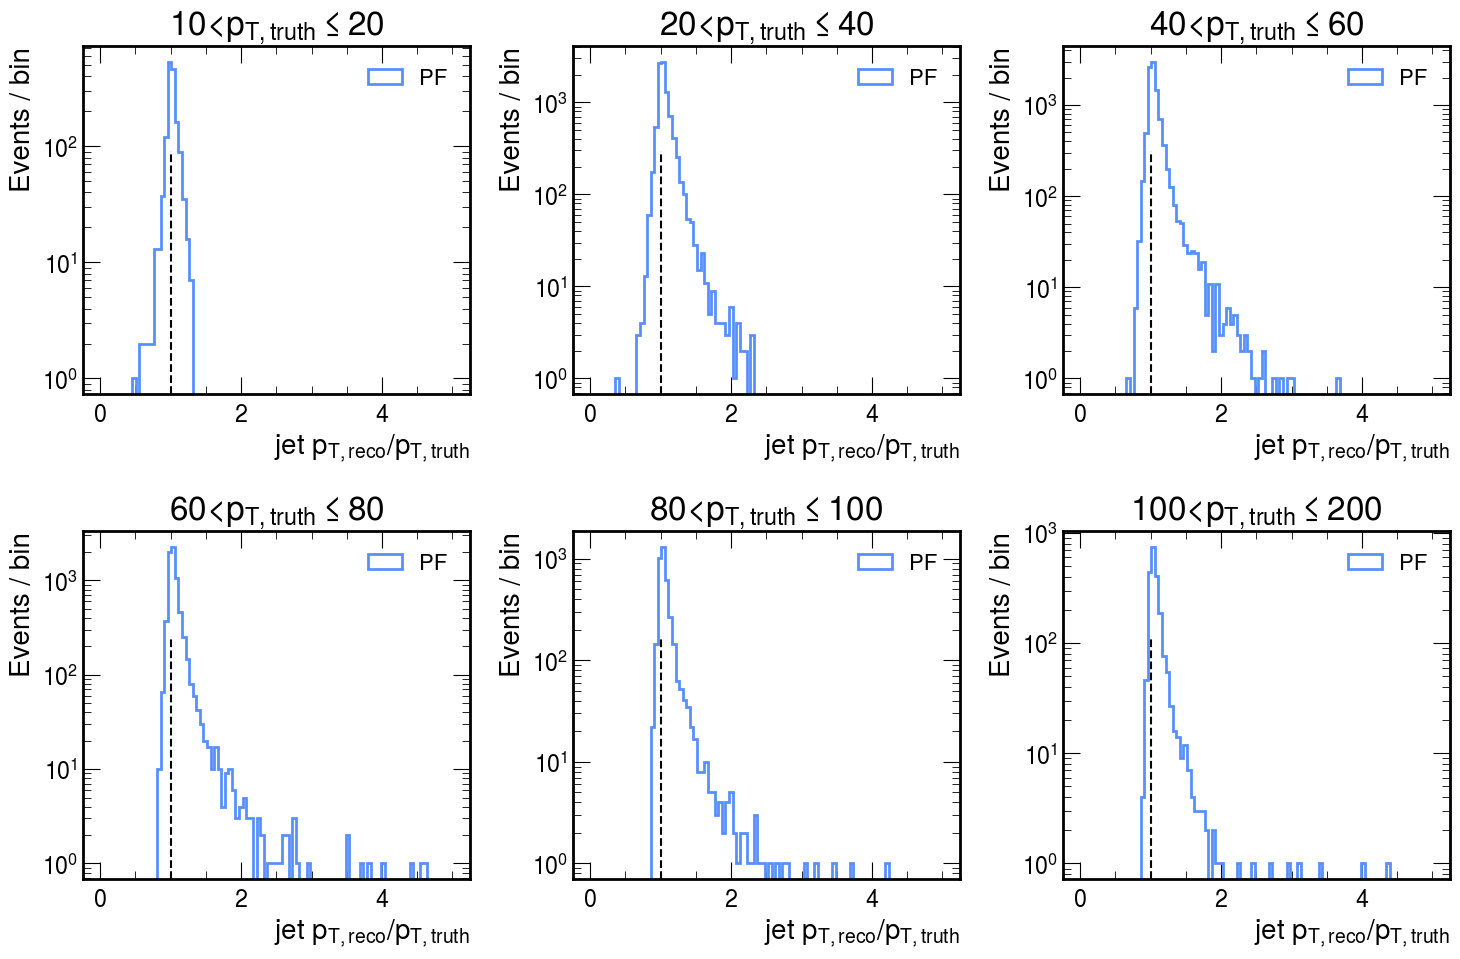

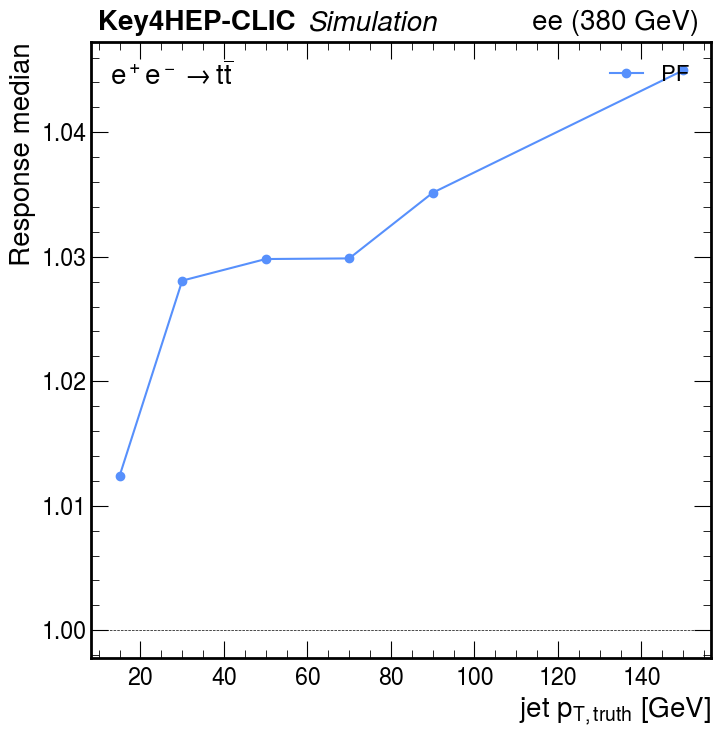

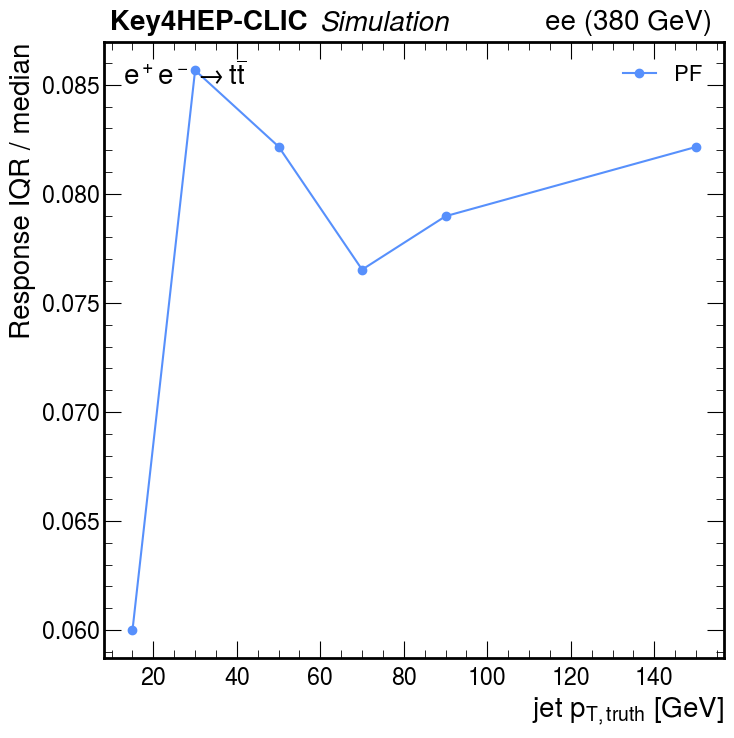

In [63]:
plot_jet_resolution(reco_dict, yvals["jet_gen_to_cand_genpt"], sample)